In [200]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from numba import jit
sns.set()
sns.set_style("darkgrid")

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import epps_singleton_2samp as epps
#from category_encoders import *

#import SimpSOM as sps
#import minisom as msom
#import sompy
from umap import UMAP
from sklearn.manifold import TSNE

import random

import gc
import os
import sys
from collections import Counter
from collections import namedtuple
from collections import defaultdict
import inspect
import itertools

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import OneClassSVM, NuSVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import HuberRegressor, RANSACRegressor, BayesianRidge, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_decomposition import PLSRegression as PLS
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import recall_score, make_scorer
#from ngboost import NGBRegressor

from sklearn.cluster import SpectralClustering, AffinityPropagation, OPTICS, AgglomerativeClustering
#from hdbscan import HDBSCAN

from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from interpret.glassbox import ExplainableBoostingClassifier as EBM

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import MaxPooling1D
from keras.callbacks import Callback
from keras.layers.convolutional import Conv1D
from keras.layers import Input 

from imblearn.over_sampling import SMOTE

In [158]:
def get_var_cols(d):
    assert isinstance(d, dict), 'input variables is not a dictionary'
    return list(itertools.chain.from_iterable(d.values()))

def _rem_cols(cd, rem):
    assert isinstance(cd, dict), 'Input variable 1 should be a dictionary'
    assert isinstance(rem, list), 'Input variable 2 should be a list'
    for _key in cd.keys():
        cd[_key] = list(set(cd[_key]) - set(rem))
    return cd

@jit
def _ssqrt(x, y):
    return np.sign(x*y)*np.sqrt(np.multiply(np.abs(x), np.abs(y)))
@jit
def _divisor(x, y, eps=1e-3):    
    return np.sign(x)*np.divide((x**2), (x**2+y**2+eps))
@jit
def _sum(x, y):
    return x+y
@jit
def expander2(x, fun=None):
    '''
        x : np array 
        fun : expansion function, assumes pairwise expansion
    '''
    num_rows, num_cols = x.shape[0], x.shape[1]
    _num_cols = np.int((num_cols**2-num_cols)/2)
    xex = np.zeros(shape=(num_rows, _num_cols)) 
    k=0
    for jl in range(0, num_cols):
        for jr in range(jl+1, num_cols):
            k +=1
            xex[:, k] =   fun(x[:,jl], x[:,jr])
    return xex

def _cols_(cols, prefix=None):
    prefix = prefix+"_" if prefix is not None else ""
    return [prefix+cols[jl]+"_"+cols[jr] for jl in range(0, len(cols)) for jr in range(jl+1, len(cols))]

@jit
def _diff_entropy(x, eps=1e-6, bins=20):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    xmean =  (xs[1:] + xs[:-1])/2
    xdiff = xs[1:] - xs[:-1]
    H = -np.sum(rhos*np.log(rhos+eps)*xdiff)
    Hr = H/np.sum(xdiff)
    return Hr

# add relative entropy  -np.sum(rhos*np.log(rhos/rhos_ref+eps)*xdiff) where rhos_ref is a reference distribution
# for the relative distribution we can use the average empirical distribution of the features

class fs_ws1():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w1_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_ws2():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w2_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_mannwhitney():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01, mode='auto'):
        # mode : 'auto', 'exact', 'asymp'
        self.pvalue = pvalue
        self.mode = mode

    def apply_test(self, pos, neg, column):
        zscore, p_value = mwu(pos[:,column], neg[:,column], alternative="less") # mode=self.mode
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_ks():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = ks2(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_epps():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = epps(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

def balanced_accuracy(y_true, y_prob, thresh=0.5):
    TP = np.sum((y_prob>thresh) & (y_true==1))
    TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
    FP = np.sum((y_prob>thresh) & (y_true==0))
    FN = np.sum((y_prob<(1-thresh)) & (y_true==1)) 
    recall = TP/(FN+TP) if (FN+TP)>0 else 0
    specificity = TN/(FP+TN) if (FP+TN)>0 else 0
    return 0.5*(recall+specificity)

def fb_score(y_true, y_prob, beta=1, thresh=0.5):
    TP = np.sum((y_prob>thresh) & (y_true==1))
    TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
    FP = np.sum((y_prob>thresh) & (y_true==0))
    FN = np.sum((y_prob<(1-thresh)) & (y_true==1))    
    prec = TP/(TP+FP)
    rec =  TP/(TP+FN)   
    return (1+beta**2)*prec*rec/(beta**2*prec+rec)

def npv(y_true, y_prob, thresh=0.5): 
    TN = np.sum((y_prob<(1-thresh)) & (y_true==0.))
    FN = np.sum((y_prob<(1-thresh)) & (y_true==1.))  
    NPV = TN/(TN+FN) if (TN+FN)>0 else 0
    return NPV

def recall(y_true, y_prob, thresh=0.5):
    TP = np.sum((y_prob>thresh) & (y_true==1))
    FN = np.sum((y_prob<(1-thresh)) & (y_true==1))
    AP = np.sum(y_true)
    recall = TP/(TP+FN) if (TP+FN)>0 else 0
    return recall, TP/AP  

def fpr(y_true, y_prob, thresh=0.5):
    TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
    FP = np.sum((y_prob>thresh) & (y_true==0))
    FPR = FP/(FP+TN) if (FP+TN)>0 else 0
    return FPR

def roc(y_true, y_prob, thresh):
    roc_arr = []
    for _thresh in thresh:
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1)) 

        TPR = TP/(TP+FN) if (TP+FN)>0 else 0
        FPR = FP/(FP+TN) if (FP+TN)>0 else 0      
        roc_arr.append((TPR, FPR))
    return roc_arr
def get_accuracy_plots(y_test, y_pred, figax = None):
    #
    if figax is None:
        fig, ax = plt.subplots(ncols=4, figsize=(28, 8))
    else:
        fig, ax = figax
        
    pd.DataFrame(y_pred).hist(bins=20, ax=ax[0], histtype='step')
    pd.DataFrame(y_test).hist(bins=2, ax=ax[0], color='black', histtype='step')
    ax[0].set_title('Proba histo')
    
    threshold = np.arange(0.,1,0.05)
    _metrics = []
    for _thresh in threshold:    
        bal_acc = balanced_accuracy(y_test, y_pred, thresh=_thresh)
        f1_score = fb_score(y_test, y_pred, beta=1, thresh=_thresh)
        _npv = npv(y_test, y_pred, thresh=_thresh)
        _fpr = fpr(y_test, y_pred, thresh=_thresh)
        rec,true_rec = recall(y_test, y_pred, thresh=_thresh)
        _metrics.append({'BAL_ACC': bal_acc, 
                        'F1_SCORE': f1_score, 
                        'NPV': _npv, 
                        'REC': rec, 
                        'TRUE_REC': true_rec, 
                        'FPR': _fpr, 
                        'AUC': metrics.roc_auc_score(y_test, y_pred),
                        'THRESHOLD': _thresh})
    _metrics = pd.DataFrame(_metrics)

    #sns.lineplot(data=_metrics, x='THRESHOLD', y='F1_SCORE', label='F1', ax=ax[1])
    sns.lineplot(data=_metrics, x='THRESHOLD', y='NPV', color='green', ax=ax[1], ci=None)
    sns.lineplot(data=_metrics, x='THRESHOLD', y='REC', color='red', ax=ax[1], ci=None)
    #sns.lineplot(data=_metrics, x='THRESHOLD', y='TRUE_REC', label='TRUE_REC', ax=ax[1])
    #sns.lineplot(data=_metrics, x='THRESHOLD', y='BAL_ACC', label='BAL_ACC', ax=ax[1])
    ax[1].set_title('Threshold dependency')   
    ax[1].set_ylabel("SCORE")
    
    # TPR / FPR -> sensitivity / 1-specifity
    roc_curve = pd.DataFrame(metrics.roc_curve(y_test, y_pred)[:2]).transpose()
    roc_curve.columns = ['FPR', 'TPR']
    sns.lineplot(data=roc_curve, x='FPR', y='TPR', ax=ax[2], ci=None)
    #sns.scatterplot(data=roc_curve, x='FPR', y='TPR', ax=ax[2],s=100)
    #ax[2].plot(np.arange(0,1,0.05),np.arange(0,1,0.05), color='black', )
    ax[2].plot(np.array([0,1]), np.array([0,1]), ls="--", c="black")
    
    prec_recall =  pd.DataFrame(metrics.precision_recall_curve(y_test, y_pred)[:2]).transpose()
    prec_recall.columns=['precision', 'recall']
    sns.lineplot(data=prec_recall, x='precision', y='recall', ax=ax[3], ci=None)
    
    return _metrics, (fig, ax)

Data transformation:
* standard scaling
* robust scaler 

Feature reduction:
* minimum univariate distribution difference
* PCA 
* UMAP

Clustering method:
* HDBSCAN
* Spectral
* SOM

This analysis should provide us with an intuition of the separability of the targets 
with the given features.

**Output**: clusters can be used as features. 

In [16]:
os.chdir("T:\laupodteam\AIOS\Bram")
HS = pd.read_csv("data/HeartScore/Data/MATRIX_FULL_23jul2019_ECG.csv", sep=";")
index_cols = ['pathos_key', 'upod_id'] 
date_cols = ['AcquisitionDateTime_ECG'] 
meta_cols = ['setsrc', 'Analyzer']
pheno_cols = ['AGE', 'gender', 'BMI', 'RF_Diab', 'RF_Smok', 'RF_HyperTens', 'RF_HyperChol', 'RF_CVDHist', 'RF_FamHist', 'RF_obese30']
ign_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_RiskFacts', 'HS_new2', 'HN_TN', 'tn_slope2']
tn_cols = ['tn_admission'] # moreve tn_slope2 and HN_TN
tn_slope_cols = ['tn_slope2']

rem_cols = ['Door']+['delay_Celldyn', 'HS_new']+date_cols+meta_cols
HS.drop(rem_cols, axis=1, inplace=True)


# convert bool in int64
for _col in HS.columns.tolist():
    if str(HS[_col].dtype)=='bool':
        HS[_col] = HS[_col].astype(int)
        
target = 'casecontrol'
HS.rename(index=str, columns={target: 'target'}, inplace=True)
tmap = {'Control': 0, 'NSTEMI': 1}
HS['target'] = HS.target.map(tmap)
#HS.drop(target, axis=1, inplace=True)

gmap = {'M': 0, 'F': 1}
HS['gender'] = HS.gender.map(gmap)

HS.set_index(index_cols, inplace=True)

cols = HS.columns.tolist()
var_cols = list(set(cols) - set(meta_cols) - set(index_cols) -set(date_cols) - set(['target']) - set(ign_cols))

cell_dyn_cols = ["c_b_wbc","c_b_wvf","c_b_neu","c_b_seg","c_b_bnd","c_b_ig","c_b_lym","c_b_lyme","c_b_vlym","c_b_mon","c_b_mone","c_b_blst",
                 "c_b_eos","c_b_bas","c_b_pneu","c_b_pseg","c_b_pbnd","c_b_pig","c_b_plym","c_b_plyme","c_b_pvlym","c_b_pmon","c_b_pmone",
                 "c_b_pblst","c_b_peos","c_b_pbas","c_b_namn","c_b_nacv","c_b_nimn","c_b_nicv","c_b_npmn","c_b_npcv","c_b_ndmn",
                 "c_b_ndcv","c_b_nfmn","c_b_nfcv","c_b_Lamn","c_b_Lacv","c_b_Limn","c_b_Licv"] # delay_Celldyn: remove
ecg_cols_agg =  ["VentricularRate_ECG","AtrialRate_ECG","P_RInterval_ECG","QRS_Duration_ECG","Q_TInterval_ECG",
                 "QTCCalculation_ECG","PAxis_ECG","RAxis_ECG","TAxis_ECG","QRSCount_ECG","QOnset_ECG",
                 "QOffset_ECG","POnset_ECG","POffset_ECG","T_Onset_ECG","T_Offset_ECG","QRS_Onset_ECG",
                 "QRS_Offset_ECG","AvgRRInterval_ECG","QTcFredericia_ECG","QTcFramingham_ECG","QTc_Bazett_ECG"]

ecg_leads = ['Lead_I_', 'Lead_II_', 'Lead_III_', 'Lead_V1_', 'Lead_V2_', 'Lead_V3_', 'Lead_V4_', 'Lead_V5_', 'Lead_V6_', 'Lead_aVF_', 'Lead_aVL_', 'Lead_aVR_']
ecg_msrmnt = ['MaxST_ECG',  'Max_R_Ampl_ECG', 'Max_S_Ampl_ECG', 'MinST_ECG', 'PFull_Area_ECG', 'PP_Area_ECG', 'PP_Duration_ECG',
 'PP_PeakAmpl_ECG', 'PP_PeakTime_ECG', 'P_Area_ECG', 'P_Duration_ECG', 'P_PeakAmpl_ECG', 'P_PeakTime_ECG', 'QRS_Area_ECG', 'QRS_Balance_ECG',
 'QRS_Deflection_ECG', 'QRSint_ECG', 'Q_Area_ECG', 'Q_Duration_ECG', 'Q_PeakAmpl_ECG', 'Q_PeakTime_ECG', 'RP_Area_ECG', 'RP_Duration_ECG', 'RP_PeakAmpl_ECG',
 'RP_PeakTime_ECG', 'R_Area_ECG', 'R_Duration_ECG', 'R_PeakAmpl_ECG', 'R_PeakTime_ECG', 'SP_Area_ECG', 'SP_Duration_ECG', 'SP_PeakAmpl_ECG', 
 'SP_PeakTime_ECG', 'STE_ECG', 'STJ_ECG', 'STM_ECG', 'S_Area_ECG', 'S_Duration_ECG', 'S_PeakAmpl_ECG', 'S_PeakTime_ECG',
 'TFull_Area_ECG', 'TP_Area_ECG', 'TP_Duration_ECG', 'TP_PeakAmpl_ECG', 'TP_PeakTime_ECG', 'T_Area_ECG', 'T_Duration_ECG', 'T_End_ECG',
 'T_PeakAmpl_ECG', 'T_PeakTime_ECG', 'T_Special_ECG', 'P_OnsetAmpl_ECG']


ecg_cols_dyn = [_lead+_msrmnt for _lead in ecg_leads for _msrmnt in ecg_msrmnt]

ecg_cols_agg = list(set(ecg_cols_agg) & set(var_cols))
ecg_cols_dyn = list(set(ecg_cols_dyn) & set(var_cols))
cell_dyn_cols = list(set(cell_dyn_cols) & set(var_cols))

ecg_cols = list(set(ecg_cols_agg+ecg_cols_dyn))
other_cols = list(set(var_cols)-set(ecg_cols)-set(cell_dyn_cols))

col_dict = {'ecg': ecg_cols, 
            'celldyn': cell_dyn_cols,
            'ecg_cols_agg': ecg_cols_agg,
            'other': other_cols}
print("ECG: {} cols, \t CELLDYN: {} cols, \t OTHER: {} cols".format(len(ecg_cols), len(cell_dyn_cols), len(other_cols)))

ECG: 646 cols, 	 CELLDYN: 40 cols, 	 OTHER: 11 cols


In [17]:
scaler= {'ecg': QuantileTransformer(n_quantiles=1000, output_distribution='normal'), 
         'celldyn': QuantileTransformer(n_quantiles=1000, output_distribution='normal'), 
         'other': MinMaxScaler()} # StandardScaler(), MinMaxScaler(), RobustScaler() or None
dim_reduction = None # {'ecg': PCA(n_components=6), 'celldyn': PCA(n_components=20)} # dict with dimension reduction per data group, or one dim red for all, or None, methods: PCA, NMF, UMAP
# dict with column name and impute type: median, mean, remove, regressor, (nmf?), or None, or knnimputer, or iterative which uses a round-robin approach using BayesianRidge as the regressor
feature_expansion = ['celldyn', 'ecg_cols_agg']

#feature_weights = 'glm' # glm, tree, gam
#clustering = 'hdbscan' # hdbscan, SOM, spectral
remove_nan_patients = False
# NGBRegressor(), BayesianRidge(), MLPRegressor(hidden_layer_sizes=(70,70,30)), https://blog.stata.com/2011/08/22/use-poisson-rather-than-regress-tell-a-friend/
# P-features, P_RInterval_ECG/POnset_ECG/PAxis_ECG/POffset_ECG, if NaN, could mean absence of initial polar. which could mean atrium fibr.
imputance = {'BMI': 'median', 
             'P_RInterval_ECG': None, 
             'POnset_ECG': None, 
             'PAxis_ECG': None, 
             'POffset_ECG': None}
missing_dummy = True
remove_nan_cols = False
variance_remove = False
remove_multicoll = False
remove_outlying_samples_from_train = False
remove_outlying_samples_from_test = False
remove_weak_univariates = True
keep_strongest_N = None # keep strongest N features based on univariate scores
remove_low_diffEntropy = False
run_supervised_umap = True

# Categorical encoding

In [18]:
# https://github.com/scikit-learn-contrib/categorical-encoding
dummy_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_new2', 'HS_RiskFacts', 'HN_TN']
HS[dummy_cols] = HS[dummy_cols].astype('category')
HS = pd.get_dummies(HS, prefix_sep={_dummy: "_dummy_" for _dummy in dummy_cols})
dummy_cols = [_col for _col in HS.columns if '_dummy_' in _col]

hs_cols = ['tn_admission']+dummy_cols

HS.loc[HS['tn_admission']>4000, 'tn_admission'] = 4000
HS.loc[HS['tn_slope2']<-100, 'tn_slope2'] = 100

HS['tn_diff_abs'] = HS[['tn_admission', 'tn_slope2']].apply(lambda x: np.sign(x[0]*x[1])*np.log10(np.abs(x[0]*x[1])+0.01), axis=1)
HS['tn_diff_rel'] = HS[['tn_admission', 'tn_slope2']].apply(lambda x: x[1]/(x[0]+1), axis=1)

tn_slope_cols=['tn_slope2', 'tn_diff_abs', 'tn_diff_rel']

# Imputance

Do not impute, rather treat missingness as a feature

In [19]:
print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=0)>0).sum()))
###
print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}\tALL {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS.isna().sum(axis=1)>0).sum()))

Num NaN columns : ECG 4	CELLDYN 0	OTHER 1
Num NaN samples : ECG 75	CELLDYN 0	OTHER 64	ALL 135


In [20]:
if remove_nan_patients:
    nan_patients = HS[var_cols].isna().sum(axis=1)[HS[var_cols].isna().sum(axis=1)>0].index
    HS.drop(index=nan_patients, inplace=True)
    print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum()))
    
    print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[other_cols].isna().sum(axis=0)>0).sum()))   

    # y = HS[['target']]

In [21]:
# imputance

# consider adding Gaussian noise on top of the prediction
# https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression
var_cols = get_var_cols(col_dict)
if missing_dummy:
    # for NaN cols, treat non-nan as 0, nan as 1
    _c = HS[var_cols].columns
    nan_cols = _c[(HS[var_cols].isna().sum()>0)==True].tolist()    
    dummy_list = []
    for _ncol in nan_cols:
        dummy_name = 'availdummy_'+_ncol
        dummy_list.append(dummy_name)
        HS[dummy_name] = (~pd.isna(HS[_ncol])).astype(int)
        var_cols.append(dummy_name)
        dummy_comb = "_".join(dummy_list)
        HS[dummy_comb] = HS[dummy_list].apply(lambda x: np.product(x), axis=1)
        col_dict['other'] = col_dict['other'] + [dummy_name, dummy_comb] # should be included in the relevant feature group (ecg, celldyn, other)
    if remove_nan_cols:
        # remove NaN cols
        HS.drop(nan_cols, axis=1, inplace=True)
        var_cols = list(set(var_cols) - set(nan_cols))
        col_dict = _rem_cols(col_dict, nan_cols)

if HS[var_cols].isna().sum().sum()>0:
    nan_cols = list(HS[var_cols].isna().sum()[HS[var_cols].isna().sum()>0].index)
    dat = HS.copy()
    if imputance is not None:
        if isinstance(imputance, dict):
            for _imp_key, _imp_val in imputance.items():
                if type(_imp_val)==str:
                    if _imp_val == 'median': 
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmedian(dat[_imp_key])
                    elif _imp_val == 'mean':
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmean(dat[_imp_key])
                    elif _imp_val == 'remove':
                        dat = dat.dropna(subset=[_imp_key])
                elif 'sklearn' in str(type(_imp_val)):  
                    _sub_cols = list(set(var_cols)  - set(nan_cols))
                    _y = dat.loc[~dat[_imp_key].isna(), _imp_key]
                    _X_train = dat.loc[~dat[_imp_key].isna(), _sub_cols]
                    _X_test = dat.loc[dat[_imp_key].isna(), _sub_cols]
                    try:
                        dat.loc[dat[_imp_key].isna(), _imp_key] = _imp_val.fit(_X_train, _y).predict(_X_test)
                    except Exception as e:
                        print("Imputance failed for {}, shapes: {}, {}, {}".format(_imp_key, _X_train.shape, _y.shape, _X_test.shape))
                        if _X_test.shape[0]==0:
                            print("Hmm, you probably already ran the imputer, please reload the data...")
        else:
            if imputance=='iterative':
                imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10)
            elif imputance=='knnimputer':
                imp= KNNImputer(n_neighbors=5)

            dat = pd.DataFrame(data=imp.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)
            dat = dat.join(dat[meta_cols])
else:
    dat = HS

# Dimension reduction

In [22]:
def _condition_number(x, ignore_nan=True):
    return np.linalg.cond(x.dropna(), p=2)

print("PRE: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                        _condition_number(dat[col_dict['celldyn']]),
                                                                        _condition_number(dat[col_dict['other']])))

PRE: Condition numbers:
		 ECG 1.3936256820818655e+18, 	 CELLDYN 5246890491.183847, 	 Other 2.4494432520720245e+36


# Feature combiner

By default 
* CELLDYN: $\frac{A}{A+B+\epsilon}$, $\sqrt{A\cdot B}$ -> +800 features
* ECG AGG: $A+B$, $\sqrt{A\cdot B}$
* OTHER: $\frac{A}{A+B+\epsilon}$, $\sqrt{A\cdot B}$ -> +600 features

In [23]:
feat_combo = dict()
feat_combo['celldyn'] = ['SQRT', 'DIV']
feat_combo['ecg_cols_agg'] = ['SQRT', 'SUM']

In [24]:
var_cols = get_var_cols(col_dict)
for _key in feature_expansion:
    print(_key)
    _cols = col_dict[_key]
    #dat[_cols] = dat[_cols].astype(np.float64)    
    tcols_sqrt, tcols_div, tcols_sum = [], [], []
    
    if('SQRT' in feat_combo[_key]):        
        tcols_sqrt = _cols_(dat[_cols].columns.tolist(), prefix='SQRT') 
        t = expander2(dat[_cols].values, fun=_ssqrt)
        dat_sqrt = pd.DataFrame(data=t, index=dat.index, columns=tcols_sqrt)
        dat = dat.join(dat_sqrt)
        
    if('DIV' in feat_combo[_key]):
        tcols_div = _cols_(dat[_cols].columns.tolist(), prefix='DIV') 
        t = expander2(dat[_cols].values, fun=_divisor)
        dat_div = pd.DataFrame(data=t, index=dat.index, columns=tcols_div)  
        dat = dat.join(dat_div)
    
    if('SUM' in feat_combo[_key]):
        tcols_sum = _cols_(dat[_cols].columns.tolist(), prefix='SUM') 
        t = expander2(dat[_cols].values, fun=_sum)
        dat_sum = pd.DataFrame(data=t, index=dat.index, columns=tcols_sum)    
        dat = dat.join(dat_sum)
    
    col_dict[_key] = list(set(_cols + tcols_sqrt + tcols_div + tcols_sum))
    if _key in ['ecg_cols_agg', 'ecg_cols_dyn']:
        col_dict['ecg'] = list(set(_cols + tcols_sqrt + tcols_div + tcols_sum))
    var_cols = list(set(var_cols + col_dict[_key]))


SQRT_cols= [_col for _col in dat.columns.tolist() if 'SQRT_' in _col]
DIV_cols = [_col for _col in dat.columns.tolist() if 'DIV_' in _col]

print('SQRT cols:', dat[SQRT_cols].apply(lambda x: sum(np.isinf(x))).sum(), dat[SQRT_cols].isna().sum().sum())
print('DIV cols:', dat[DIV_cols].apply(lambda x: sum(np.isinf(x))).sum(), dat[DIV_cols].isna().sum().sum())
#
print('ECG cols:', dat[col_dict['ecg']].apply(lambda x: sum(np.isinf(x))).sum(), dat[col_dict['ecg']].isna().sum().sum())
print('CELLDYN cols:', dat[col_dict['celldyn']].apply(lambda x: sum(np.isinf(x))).sum(), dat[col_dict['celldyn']].isna().sum().sum())
#

gc.collect()
dat_unscaled = dat.copy()

celldyn
ecg_cols_agg
SQRT cols: 0 0
DIV cols: 0 0
ECG cols: 0 0
CELLDYN cols: 0 0


## Scaling

In [25]:
# Scaling 
# if not embedding..
if scaler is not None:
    if isinstance(scaler, dict):        
        for _imp_key, _scaler in scaler.items():
            if _scaler is not None:
                dat[col_dict[_imp_key]] = _scaler.fit_transform(dat[col_dict[_imp_key]]) 
    else:    
        dat[var_cols] = pd.DataFrame(data=scaler.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)


In [26]:
dat.apply(lambda x: sum(np.isinf(x))).sum(), dat.isna().sum().sum()

(0, 0)

### Relative variance

In [27]:
if variance_remove:
    def remove_min_variance(x, threshold=0.001):
        cols_to_keep = (x.var()/(x.max()-x.min()))\
            [((x.var()/(x.max()-x.min()))>threshold)].index   
        drop_cols = list(set(x.columns)-set(cols_to_keep))
        return x[cols_to_keep], drop_cols

    tmp_keep, drop_cols = remove_min_variance(dat[var_cols], threshold=0.001)
    print("Removing {} columns due to lack of variance".format(dat[var_cols].shape[1] - tmp_keep.shape[1]))

    col_dict['ecg'] = set(col_dict['ecg']).difference(set(drop_cols))
    col_dict['celldyn'] = set(col_dict['celldyn']).difference(set(drop_cols))
    col_dict['other'] = set(col_dict['other']).difference(set(drop_cols))
    var_cols = set(var_cols).difference(set(drop_cols))


    (tmp_keep.std()/(tmp_keep.max() - tmp_keep.min())).plot.hist(bins=50)
    plt.title('Relative STD')

    col_dict = {'ecg': list(col_dict['ecg']), 'celldyn': list(col_dict['celldyn']), 'other': list(col_dict['other'])}

    print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['other']])))

We also want to deal with the very large variance features as they may contain little information, yet 

In [28]:
large_variance_features = dat[var_cols].columns[dat[var_cols].std()>0.3]

To remove low-variant features is actually to remove low entropy features. As the idea of low variance is completely dependent on the scaling of the feature low entropy will give a 
more robust feature filter. For continuous variables we have to use *differential entropy*, described as; 
$$H = - \int \rho(x) \ln \rho(x) dx $$

The best we can do is to approximate this using the histograms of the features;

$$H \approx - \sum \rho(b_i) \ln \rho(b_i) \Delta x_i$$

where $b_i$ represent the bins. To bound it between zero and one we should write

$$H \approx - \frac{\sum \rho(b_i) \ln \rho(b_i) \Delta x_i}{\sum \Delta x_i}$$

Note that the correct differential entropy is actually written as 
$$H = - \int \rho(x) \ln \frac{\rho(x)}{m(x)} dx $$

where $m(x)$ is the invariant measure.

In [29]:
var_cols = get_var_cols(col_dict)
feat_entropy = pd.DataFrame(data=dat[var_cols].apply(func=_diff_entropy, axis=0).apply(pd.Series))
feat_entropy.columns = ['Hr']

<ipython-input-15-b1b151840d22>:41: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_diff_entropy" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-15-b1b151840d22> (43)

File "<ipython-input-15-b1b151840d22>", line 43:
def _diff_entropy(x, eps=1e-6, bins=20):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    ^

  @jit
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "_diff_entropy" was compiled in object mode without forceobj=True.

File "<ipython-input-15-b1b151840d22>", line 42:
@jit
def _diff_entropy(x, eps=1e-6, bins=20):
^

  state.func_ir.loc))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numba\object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is depreca

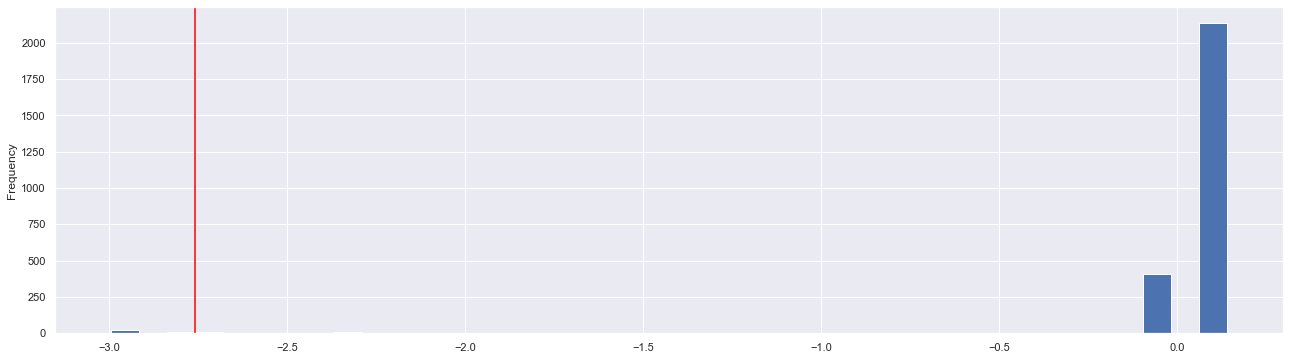

In [30]:
fig, ax = plt.subplots(figsize=(22,6))
feat_entropy.Hr.plot.hist(bins=40, ax=ax)
ax.axvline(feat_entropy.Hr.quantile(0.01), color='red')

HIGH 2550 LOW 47


Text(0.5, 1.0, 'low differential entropy')

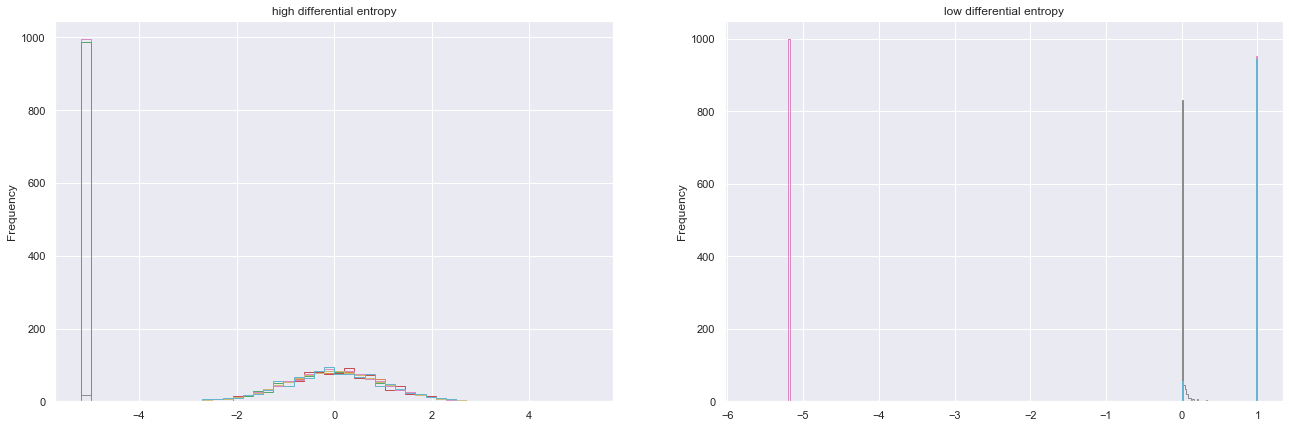

In [31]:
high_hr = feat_entropy.loc[(feat_entropy.Hr>-2)].index
low_hr = feat_entropy.loc[(feat_entropy.Hr<-2)].index
print("HIGH", len(high_hr), "LOW", len(low_hr))

fig, ax = plt.subplots(ncols=2, figsize=(22,7))
n = 20 
N = len(high_hr)
for i in range(0, n):
    j = np.random.randint(0, N)
    dat[high_hr[j]].plot.hist(bins=50, histtype='step', ax=ax[0])
ax[0].set_title('high differential entropy')
N = len(low_hr)    
for i in range(0, n):
    j = np.random.randint(0, N)
    dat[low_hr[j]].plot.hist(bins=50, histtype='step', ax=ax[1])
ax[1].set_title('low differential entropy')


In [32]:
# remove low HR cols
if remove_low_diffEntropy:
    dat.drop(list(low_hr), axis=1, inplace=True)
    col_dict = _rem_cols(col_dict, list(low_hr))

## feature selection

We use the union of featuresets obtained by applying 
* ANOVA 
* KS
* mutual information value

with visually determined cut-off values. Of course there is a range of alternatives such as recursive feature elimination but that is beyond the scope of this work.

Perhaps there is something wrong with your scaling?
!! 	 Remove the multicollinearity of the input matrix 	!!


c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_hypotests.py:106: RuntimeWarning: divide by zero encountered in true_divide
  ts = np.reshape(t, (-1, 1)) / sigma
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_hypotests.py:109: RuntimeWarning: invalid value encountered in multiply
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_hypotests.py:109: RuntimeWarning: invalid value encountered in cos
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_hypotests.py:109: RuntimeWarning: invalid value encountered in sin
  gx = np.vstack((np.cos(ts*x), np.sin(ts*x))).T  # shape = (nx, 2*len(t))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_hypotests.py:110: RuntimeWarning: i

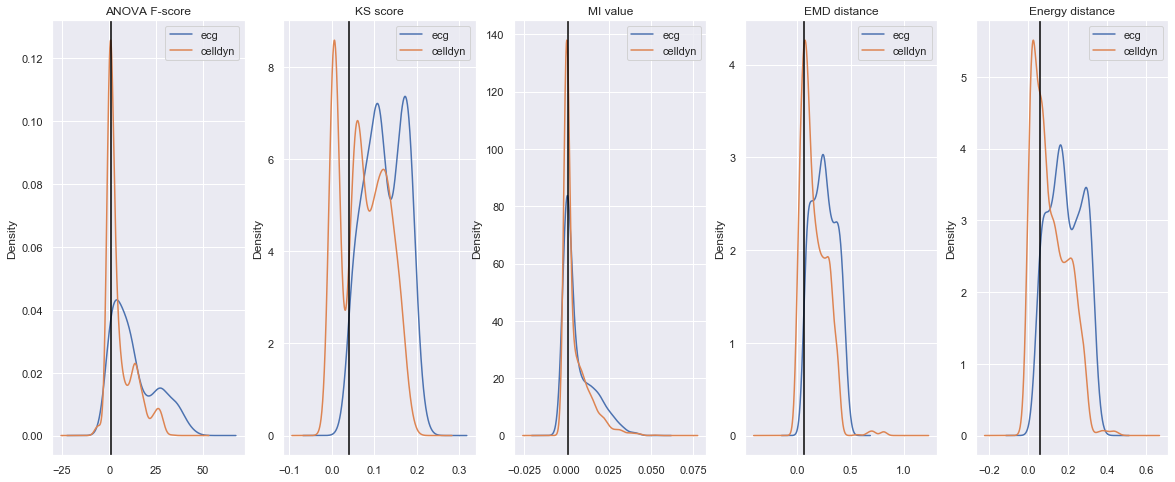

In [33]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

y = dat['target']

if remove_weak_univariates:
    anov = dict()
    anov['celldyn'] = pd.DataFrame(data=f_classif(dat[col_dict['celldyn']], y), columns=col_dict['celldyn'], index=['F', 'pval']).T
    anov['ecg'] = pd.DataFrame(data=f_classif(dat[col_dict['ecg']], y), columns=col_dict['ecg'], index=['F', 'pval']).T
    anov['other'] = pd.DataFrame(data=f_classif(dat[col_dict['other']], y), columns=col_dict['other'], index=['F', 'pval']).T

    chisq = dict()
    chisq['celldyn'] = pd.DataFrame(data=chi2(dat[col_dict['celldyn']].abs(), y), columns=col_dict['celldyn'], index=['Chi', 'pval']).T
    chisq['ecg'] = pd.DataFrame(data=chi2(dat[col_dict['ecg']].abs(), y), columns=col_dict['ecg'], index=['Chi', 'pval']).T
    chisq['other'] = pd.DataFrame(data=chi2(dat[col_dict['other']].abs(), y), columns=col_dict['other'], index=['Chi', 'pval']).T

    mi = dict()
    mi['celldyn'] = pd.DataFrame(data=mutual_info_classif(dat[col_dict['celldyn']].abs(), y), index=col_dict['celldyn'], columns=['mi'])
    mi['ecg'] = pd.DataFrame(data=mutual_info_classif(dat[col_dict['ecg']].abs(), y), index=col_dict['ecg'], columns=['mi'])
    mi['other'] = pd.DataFrame(data=mutual_info_classif(dat[col_dict['other']].abs(), y), index=col_dict['other'], columns=['mi'])


    ks_dist = dict()
    KS = fs_ks()
    KS.fit(dat[col_dict['other']].values, y)
    ks_dist['other'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['other'])

    KS.fit(dat[col_dict['celldyn']].values, y)
    ks_dist['celldyn'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['celldyn'])

    KS.fit(dat[col_dict['ecg']].values, y)
    ks_dist['ecg'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['ecg'])

    try:
        mwu_dist = dict()
        MW = fs_mannwhitney()
        MW.fit(dat[col_dict['other']].values, y)
        mwu_dist['other'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['other'])

        MW.fit(dat[col_dict['celldyn']].values, y)
        mwu_dist['celldyn'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['celldyn'])

        MW.fit(dat[col_dict['ecg']].values, y)
        mwu_dist['ecg'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['ecg'])

        mwu_dist['celldyn']['MWS'] = 4*(mwu_dist['celldyn']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
        mwu_dist['ecg']['MWS'] = 4*(mwu_dist['ecg']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
        mwu_dist['other']['MWS'] = 4*(mwu_dist['other']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
    except Exception as e:
        print("Perhaps there is something wrong with your scaling?")

    try:
        epps_dist = dict()
        EPPS = fs_epps()
        EPPS.fit(dat[col_dict['other']].values, y)
        epps_dist['other'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['other'])

        EPPS.fit(dat[col_dict['ecg']].values, y)
        epps_dist['ecg'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['ecg'])

        EPPS.fit(dat[col_dict['celldyn']].values, y)
        epps_dist['celldyn'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['celldyn'])
    except Exception as e:
        if str(e)=='SVD did not converge':
            print("!! \t Remove the multicollinearity of the input matrix \t!!")
        else:
            print("Oooeps: {}".format(e))

    # w1
    wass1_dist = dict()
    W1D = fs_ws1()
    W1D.fit(dat[col_dict['other']].values, y)
    wass1_dist['other'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['other'])

    W1D.fit(dat[col_dict['celldyn']].values, y)
    wass1_dist['celldyn'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['celldyn'])

    W1D.fit(dat[col_dict['ecg']].values, y)
    wass1_dist['ecg'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['ecg'])

    # w2
    wass2_dist = dict()
    W2D = fs_ws2()
    W2D.fit(dat[col_dict['other']].values, y)
    wass2_dist['other'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['other'])

    W2D.fit(dat[col_dict['celldyn']].values, y)
    wass2_dist['celldyn'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['celldyn'])

    W2D.fit(dat[col_dict['ecg']].values, y)
    wass2_dist['ecg'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['ecg'])

    ##############
    ### FILTER ###
    ##############
#if remove_weak_univariates:
    fig, ax = plt.subplots(ncols=5, figsize=(20, 8))
    anov['ecg'].F.plot.kde(label='ecg', ax=ax[0])
    anov['celldyn'].F.plot.kde(label='celldyn', ax=ax[0])
    ax[0].set_title("ANOVA F-score")
    ax[0].axvline(1, color='black')
    ax[0].legend()
    
    ks_dist['ecg'].KS.plot.kde(label='ecg', ax=ax[1])
    ks_dist['celldyn'].KS.plot.kde(label='celldyn', ax=ax[1])
    ax[1].set_title("KS score")    
    ax[1].axvline(0.04, color='black')
    ax[1].legend()
    
    mi['ecg'].mi.plot.kde(label='ecg', ax=ax[2])
    mi['celldyn'].mi.plot.kde(label='celldyn', ax=ax[2])
    ax[2].set_title("MI value")
    ax[2].axvline(0.001, color='black')
    ax[2].legend()
    
    wass1_dist['ecg'].W1.plot.kde(label='ecg', ax=ax[3])
    wass1_dist['celldyn'].W1.plot.kde(label='celldyn', ax=ax[3])
    ax[3].set_title("EMD distance")
    ax[3].axvline(0.06, color='black')
    ax[3].legend()
    
    wass2_dist['ecg'].W2.plot.kde(label='ecg', ax=ax[4])
    wass2_dist['celldyn'].W2.plot.kde(label='celldyn', ax=ax[4])
    ax[4].set_title("Energy distance")
    ax[4].axvline(0.06, color='black')
    ax[4].legend()

In [34]:
if remove_weak_univariates:
    ecg_inc_ks = ks_dist['ecg'][ks_dist['ecg'].KS>0.05].index.tolist()
    celldyn_inc_ks = ks_dist['celldyn'][ks_dist['celldyn'].KS>0.05].index.tolist()
    
    ecg_inc_anova = anov['ecg'][anov['ecg'].F>1].index.tolist()
    celldyn_inc_anova = anov['celldyn'][anov['celldyn'].F>1].index.tolist()

    ecg_inc_mi = mi['ecg'][mi['ecg'].mi>0.001].index.tolist()
    celldyn_inc_mi = mi['celldyn'][mi['celldyn'].mi>0.001].index.tolist()

    
    ecg_inc_wass = wass1_dist['ecg'][wass1_dist['ecg'].W1>0.05].index.tolist()
    celldyn_inc_wass = wass1_dist['celldyn'][wass1_dist['celldyn'].W1>0.05].index.tolist()

    ecg_inc_wass2 = wass2_dist['ecg'][wass2_dist['ecg'].W2>0.05].index.tolist()
    celldyn_inc_wass2 = wass2_dist['celldyn'][wass2_dist['celldyn'].W2>0.05].index.tolist()
    
    tot_scores_ecg = pd.concat([ks_dist['ecg'], anov['ecg'], wass1_dist['ecg'], wass2_dist['ecg'], mi['ecg'], chisq['ecg']], axis=1)
    tot_scores_celldyn = pd.concat([ks_dist['celldyn'], anov['celldyn'], wass1_dist['celldyn'], wass2_dist['celldyn'], mi['celldyn'], chisq['celldyn']], axis=1)

    tot_scores_ecg.drop('pval', axis=1, inplace=True)
    tot_scores_celldyn.drop('pval', axis=1, inplace=True)

    mmscaler = MinMaxScaler()
    X=mmscaler.fit_transform(tot_scores_ecg)
    cols=tot_scores_ecg.columns.tolist()
    ecg_scores = pd.DataFrame(data=X, index=tot_scores_ecg.index, columns=cols)

    X=mmscaler.fit_transform(tot_scores_celldyn)
    cols=tot_scores_celldyn.columns.tolist()
    celldyn_scores = pd.DataFrame(data=X, index=tot_scores_celldyn.index, columns=cols)

    ecg_scores['AVG'] =ecg_scores.apply(lambda x: x.mean(), axis=1)
    celldyn_scores['AVG'] = celldyn_scores.apply(lambda x: x.mean(), axis=1)    
    
    print("PRE: ECG cols {}, CELLDYN cols {}".format(len(col_dict['ecg']), len(col_dict['celldyn'])))
    
    if isinstance(keep_strongest_N, int):
        assert keep_strongest_N>50, 'Sorry, we want a minimum of 50 features'
        # we have keep_strongest_N features to keep
        # we want to prune the ecg, celldyn features
        Ntot = keep_strongest_N - (dat.shape[1]-len(col_dict['ecg'])-len(col_dict['celldyn']))
        # we use the number of the current ecg/celldyn cols as the weights
        Necg, Ncelldyn = len(col_dict['ecg']), len(col_dict['celldyn'])
        w_ecg, w_celldyn = Necg/(Necg+Ncelldyn), Ncelldyn/(Necg+Ncelldyn)
        Necg = int(w_ecg*Ntot)
        Ncelldyn = int(w_celldyn*Ntot)
        # we want to keep only the top features
        ecg_cols_to_keep = ecg_scores.sort_values('AVG', ascending=False)[:Necg].index.tolist()
        celldyn_cols_to_keep = celldyn_scores.sort_values('AVG', ascending=False)[:Ncelldyn].index.tolist()
        
        col_dict['ecg'] = list(set(ecg_cols_to_keep))
        col_dict['celldyn'] = list(set(celldyn_cols_to_keep))
    else:
        col_dict['ecg'] = list(set(ecg_inc_anova+ecg_inc_mi+ecg_inc_ks+ecg_inc_wass+ecg_inc_wass2))
        col_dict['celldyn'] = list(set(celldyn_inc_anova+celldyn_inc_mi+celldyn_inc_ks+celldyn_inc_wass+celldyn_inc_wass2))
    
    print("POST: ECG cols {}, CELLDYN cols {}".format(len(col_dict['ecg']), len(col_dict['celldyn'])))
    
    var_cols = get_var_cols(col_dict)
    

PRE: ECG cols 484, CELLDYN cols 1600
POST: ECG cols 484, CELLDYN cols 1440


## Multi-collinearity

I.e. **the problem of removing all correlated pairs as efficiently as possible, meaning by removing a minimum number of nodes at the lowest computational cost.**

The efficient removal of multicollinearity can be cast in graph optimisation problem.

* Maximal Clique Enumeration (MCE): from all the maximal non-overlapping cliques, keep only the node with the lowest mean similarity. This is iterative; 
    * start with the largest cliques, exclude, redetermine cliques, exclude, etc. Until only pairs are left
    * Remove all nodes with occurrence > 1, then randomly remove nodes   
* Recursively remove 50% of the pairs until no pairs are left
* Instead of removing the collinear pairs multiply them. 

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.metrics.pairwise import cosine_similarity as cosim

def coll_cols(x, threshold=0.99, how='corr_aff', ignore_nan=True):
    '''
     x : df
     threshold : maximum correlation or maximum VIF
     how : correlation (corr_aff, corr_pair) of VIF-based (vif)
    '''
    cols = x.columns.tolist()
    if ignore_nan:
        x=x.dropna() # x.fillna(x.median())   
    if how=='vif':
        cols_to_remove = []
        x = add_constant(x)
        x[cols] = StandardScaler().fit_transform(x[cols]) 
        vifs = []
        for idx, col in tqdm(enumerate(cols)):
            _vif = vif(x.values, idx)
            if _vif != np.inf:                
                vifs.append(_vif)
            if vif(x.values, idx)>threshold:
                cols_to_remove.append(col)
        vifs = np.array(vifs)
        print("VIF:\t max {}, \t min {}, \t mean {}, \t median {}".format(vifs.max(), vifs.min(), vifs.mean(), np.median(vifs)))
        plt.hist(np.log10(vifs), bins=50, density=True)
    elif how=='corr_aff':
        corrcoefs = x.corr().values  # np.corrcoef(tmp[var_cols]) , tmp[var_cols].corr().values         

        AF = AffinityPropagation(damping=0.65, max_iter=200, convergence_iter=50, preference=None, affinity='precomputed')
        labels = AF.fit_predict(-1/corrcoefs**2)
        exemplars = AF.cluster_centers_indices_
        cols_to_remove = [var_cols[i] for i in exemplars]
    elif how=='corr_pair':
        # simplistic 
        corrcoefs = cosim(np.transpose(x)) # cosim(x) # x.corr().values # np.abs(np.corrcoef(x, rowvar=False)), cosim(x)
        print(corrcoefs.shape, x.shape)
        conn_count = { k: 0 for k in cols}
        conn_nodes = defaultdict(list)
        for idx, _colx in enumerate(cols):
            for jdx, _coly in enumerate(cols):
                if jdx<idx:
                    if corrcoefs[idx, jdx]>threshold:
                        conn_count[_colx]  += 1
                        conn_count[_coly]  += 1
                        conn_nodes[_colx]  += [_coly]
                        conn_nodes[_coly]  += [_colx]         
        cols_to_remove = [_v[0] for _v in conn_nodes.values()]
        
    print("{} columns should be removed due to collinearity.".format(len(cols_to_remove)))  
    return cols_to_remove
if remove_multicoll:
    drop_cols = coll_cols(dat[col_dict['ecg']], how='corr_pair', threshold=0.98, ignore_nan=False)
    col_dict['ecg'] = list(set(col_dict['ecg']).difference(set(drop_cols)))

    drop_cols = coll_cols(dat[col_dict['celldyn']], how='corr_pair', threshold=0.98, ignore_nan=False)
    col_dict['celldyn'] = list(set(col_dict['celldyn']).difference(set(drop_cols)))

    #drop_cols = coll_cols(dat[col_dict['other']], how='vif', threshold=0.98, ignore_nan=False)
    #col_dict['other'] = list(set(col_dict['other']).difference(set(drop_cols)))

    #var_cols = list(set(var_cols).difference(set(drop_cols)))

    print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['other']])))

## embedding
* PCA
* UMAP
* NMF

In [36]:
# Dim reduction
if dim_reduction is not None:
    if isinstance(dim_reduction, dict):
        assert(set(dim_reduction.keys()).issubset(['ecg', 'celldyn'])), "Check the dim_reduction keys"
        ecols = ['ecg_'+str(i) for i in range(0, dim_reduction['ecg'].n_components)]
        ecg_red = pd.DataFrame(dim_reduction['ecg'].fit_transform(dat[ecg_cols]), index=dat.index, columns=ecols)
        ccols = ['celldyn_'+str(i) for i in range(0, dim_reduction['celldyn'].n_components)]
        celldyn_red = pd.DataFrame(dim_reduction['celldyn'].fit_transform(dat[cell_dyn_cols]), index=dat.index, columns=ccols)
        
        dat_red = dat[other_cols].join(ecg_red).join(celldyn_red)
    else:
        rcols = ['red_'+str(i) for i in range(0, dim_reduction['ecg'].n_components)]
        tot_red = pd.DataFrame(dim_reduction.fit_transform(dat[var_cols]), index=dat.index, columns=rcols)
        dat_red = dat[other_cols].join(tot_red)

## Outliers

In [37]:
# Mahalanobis distance for outliers
def mahalanobis(x=None, cov=None):
    # source: https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(x)
    if not cov:
        cov = np.cov(x.values.T)
    inv_covmat = sc.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

if remove_outlying_samples_from_train:
    var_cols = get_var_cols(col_dict)

    out_idx_dict= {}

    iso = IsolationForest(n_estimators=600, n_jobs=4)
    out_in = iso.fit_predict(dat[var_cols])
    out_idx_dict['iso'] = np.where(out_in==-1)
    in_idx = np.where(out_in==1)
    
    pd.DataFrame(iso.score_samples(dat[var_cols])).plot.kde()

    ocs = OneClassSVM(kernel='rbf', gamma='scale', max_iter=1000)
    out_in = ocs.fit_predict(dat[var_cols])
    out_idx_dict['svm'] = np.where(out_in==-1)

    try:
        mah = mahalanobis(dat[var_cols])
        dat['_maha'] = mah/(np.max(mah)-np.min(mah))
        # isolation forest
        dat._maha.plot.hist(bins=50)
    except:
        print("matrix is singular..you did not remove the collinearity did you ;)")

## Reduced dimensionality visualisation

### PCA

In [38]:
print("ECG: {} cols, \t CELLDYN: {} cols, \t OTHER:{} cols".format(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['other'])))

ECG: 484 cols, 	 CELLDYN: 1440 cols, 	 OTHER:29 cols


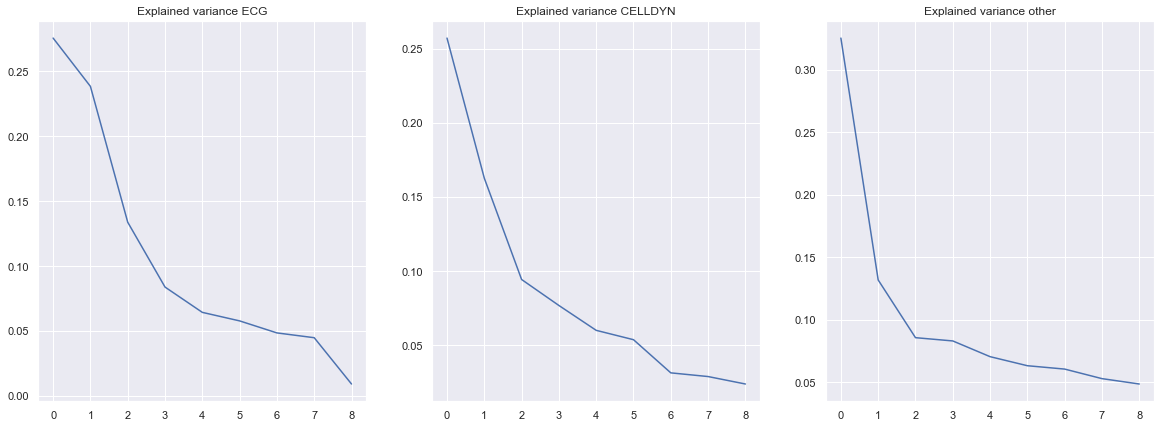

In [39]:
dat_viz={}
nc = 9
red_cols = ['pc_'+str(i) for i in range(0, nc)]
pc = {}
fig, ax = plt.subplots(ncols=3, figsize=(20,7))

pc['ecg'] = PCA(n_components=nc, svd_solver='full')
tred = pc['ecg'].fit_transform(dat[col_dict['ecg']])
ax[0].plot(pc['ecg'].explained_variance_ratio_)
ax[0].set_title('Explained variance ECG')
dat_viz['pca_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['celldyn'] = PCA(n_components=nc, svd_solver='full')
tred = pc['celldyn'].fit_transform(dat[col_dict['celldyn']])
ax[1].plot(pc['celldyn'].explained_variance_ratio_)
ax[1].set_title('Explained variance CELLDYN')
dat_viz['pca_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['other'] = PCA(n_components=nc, svd_solver='full')
tred = pc['other'].fit_transform(dat[col_dict['other']])
ax[2].plot(pc['other'].explained_variance_ratio_)
ax[2].set_title('Explained variance other')
dat_viz['pca_other'] = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

The explained variance of the first component is huge, this suggests that there is a leaking feature.

Text(0.5, 1.0, 'other PC 2')

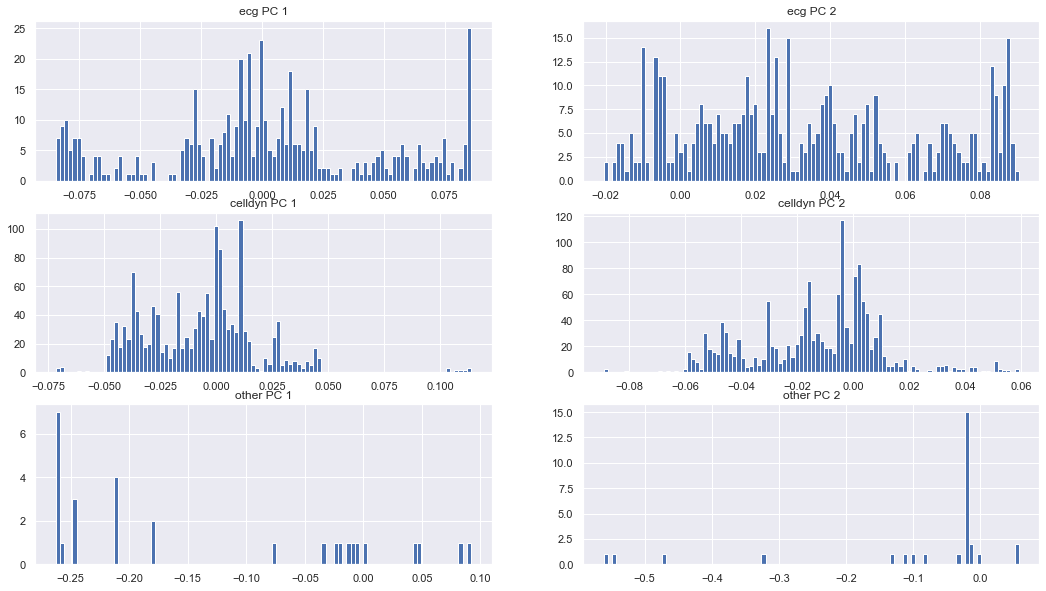

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
ax[0,0].hist(pc['ecg'].components_[0], bins=100); ax[0,0].set_title('ecg PC 1')
ax[0,1].hist(pc['ecg'].components_[1], bins=100); ax[0,1].set_title('ecg PC 2')
ax[1,0].hist(pc['celldyn'].components_[0], bins=100); ax[1,0].set_title('celldyn PC 1')
ax[1,1].hist(pc['celldyn'].components_[1], bins=100); ax[1,1].set_title('celldyn PC 2')
ax[2,0].hist(pc['other'].components_[0], bins=100); ax[2,0].set_title('other PC 1')
ax[2,1].hist(pc['other'].components_[1], bins=100); ax[2,1].set_title('other PC 2')

Text(0.5, 1.0, 'PCA OTHER')

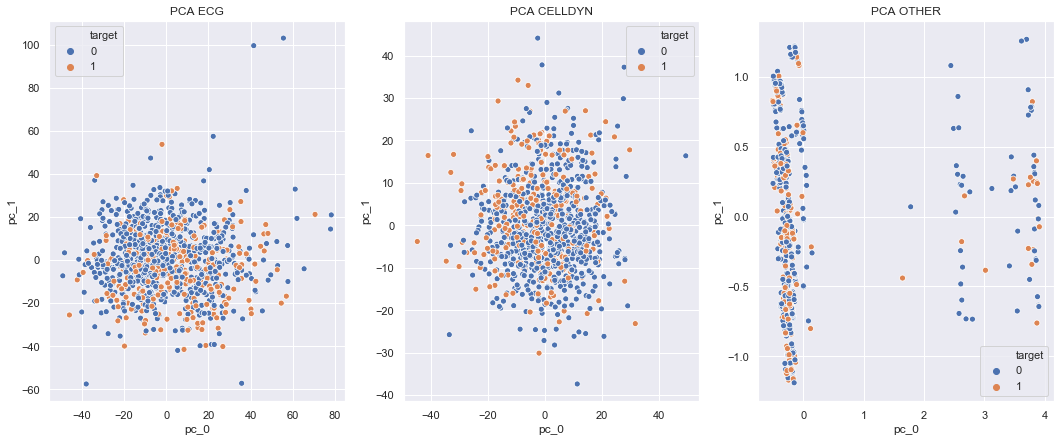

In [41]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['pca_ecg'], x='pc_0', y='pc_1', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['pca_celldyn'], x='pc_0', y='pc_1', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['pca_other'], x='pc_0', y='pc_1', hue=y, ax=ax[2])
ax[0].set_title('PCA ECG')
ax[1].set_title('PCA CELLDYN')
ax[2].set_title('PCA OTHER')

## NMF

In [42]:
nc = 20
red_cols = ['pc_'+str(i) for i in range(0, nc)]

nnmf = {}
nnmf['ecg'] = NMF(n_components=nc)
tred = nnmf['ecg'].fit_transform(dat[col_dict['ecg']]+dat[col_dict['ecg']].min().abs())
dat_viz['nmnf_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['celldyn'] = NMF(n_components=nc)
tred = nnmf['celldyn'].fit_transform(dat[col_dict['celldyn']]+dat[col_dict['celldyn']].min().abs())
dat_viz['nmnf_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['other'] = NMF(n_components=nc)
tred = nnmf['other'].fit_transform(dat[col_dict['other']]+dat[col_dict['other']].min().abs())
dat_viz['nmnf_other']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

print("Reconstruction errors: ECG {}, \t CELLDYN {}, \t OTHER {}".format(nnmf['ecg'].reconstruction_err_, 
                                                                         nnmf['celldyn'].reconstruction_err_,
                                                                         nnmf['other'].reconstruction_err_))

Reconstruction errors: ECG 95.19362044546918, 	 CELLDYN 359.9961482888735, 	 OTHER 1.4763923414262095


Text(0.5, 1.0, 'NMF OTHER')

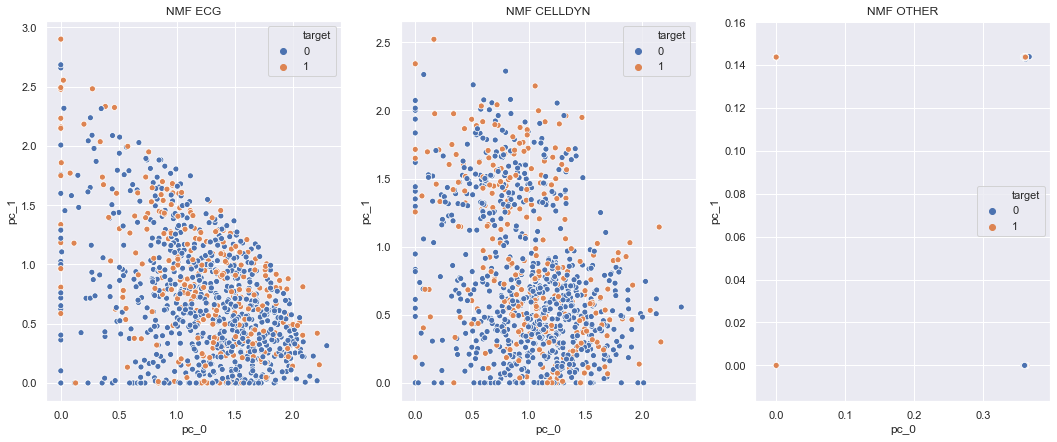

In [43]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['nmnf_ecg'], x='pc_0', y='pc_1', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['nmnf_celldyn'], x='pc_0', y='pc_1', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['nmnf_other'], x='pc_0', y='pc_1', hue=y, ax=ax[2])
ax[0].set_title('NMF ECG')
ax[1].set_title('NMF CELLDYN')
ax[2].set_title('NMF OTHER')

### UMAP

In [44]:
um_ecg = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_celldyn = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_other = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_all = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_otherHS = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)

tsne_ecg = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_celldyn = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_other = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_all = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_otherHS = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)


In [45]:
var_cols = [__val for _val in col_dict.values() for __val in _val]
dat_viz['umap_other'] =  pd.DataFrame(data=um_other.fit_transform(dat[col_dict['other']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_ecg'] = pd.DataFrame(data=um_ecg.fit_transform(dat[col_dict['ecg']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_celldyn'] = pd.DataFrame(data=um_celldyn.fit_transform(dat[col_dict['celldyn']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_all'] = pd.DataFrame(data=um_all.fit_transform(dat[var_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_otherHS'] = pd.DataFrame(data=um_all.fit_transform(dat[col_dict['other']+hs_cols]), index=dat.index, columns=['pc_1', 'pc_2'])


dat_viz['tsne_other'] =  pd.DataFrame(data=tsne_other.fit_transform(dat[col_dict['other']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_ecg'] = pd.DataFrame(data=tsne_ecg.fit_transform(dat[col_dict['ecg']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_celldyn'] = pd.DataFrame(data=tsne_celldyn.fit_transform(dat[col_dict['celldyn']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_all'] = pd.DataFrame(data=tsne_all.fit_transform(dat[var_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_otherHS'] = pd.DataFrame(data=tsne_all.fit_transform(dat[col_dict['other']+hs_cols]), index=dat.index, columns=['pc_1', 'pc_2'])

Text(0.5, 1.0, 'TSNE ALL')

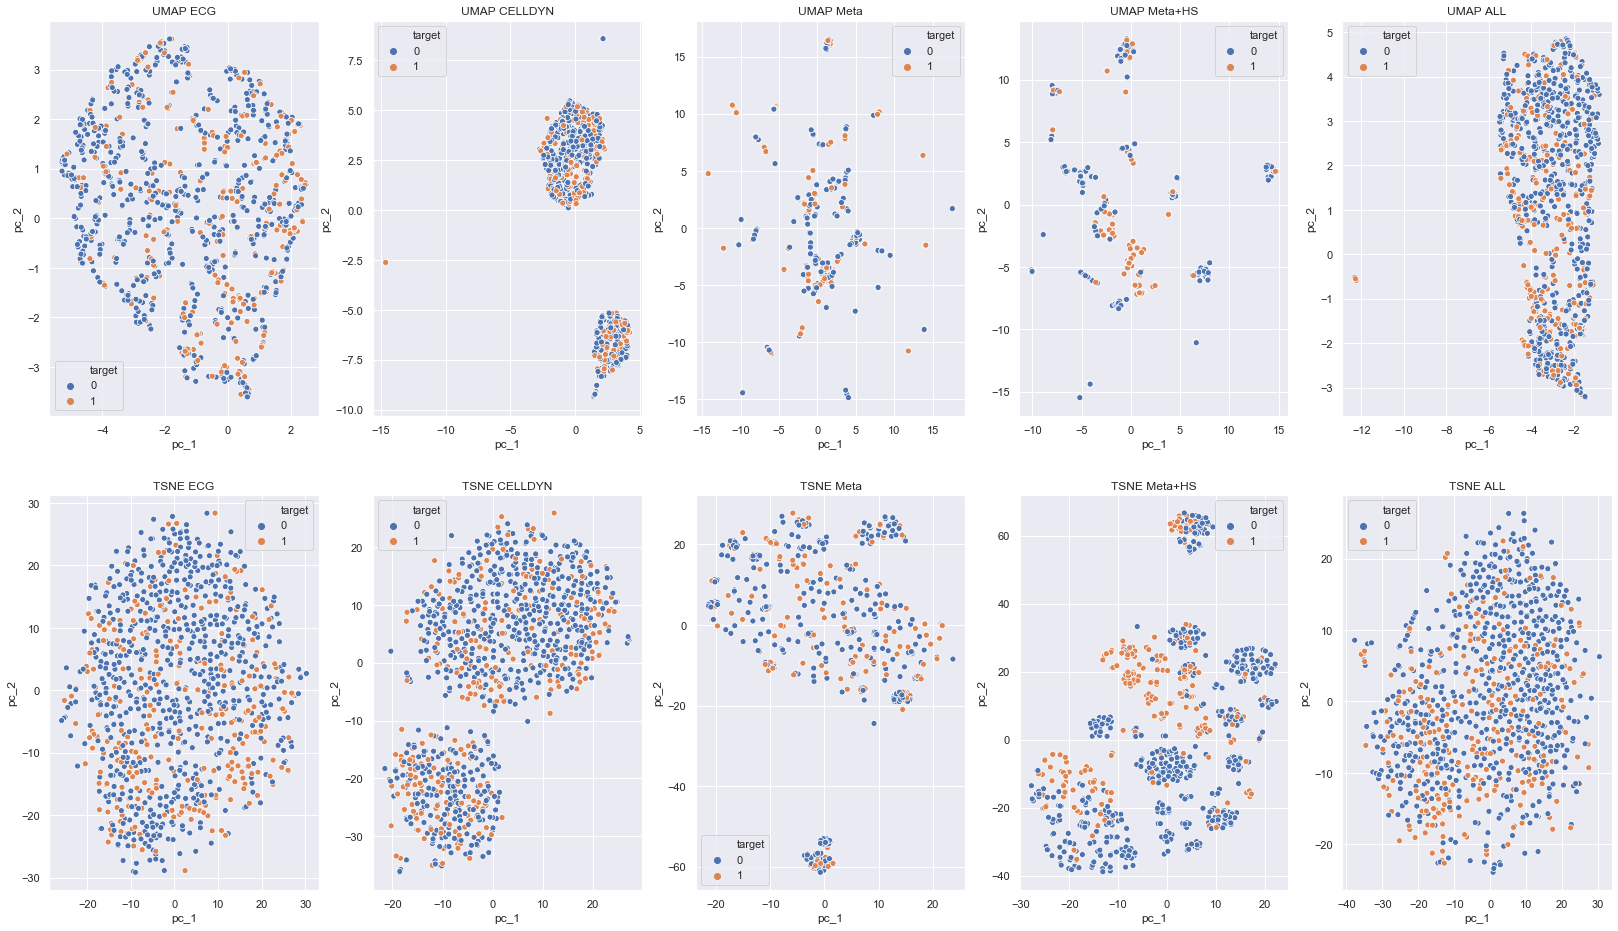

In [46]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(28,16))
sns.scatterplot(data=dat_viz['umap_ecg'], x='pc_1', y='pc_2', hue=y, ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[0,1])
sns.scatterplot(data=dat_viz['umap_other'], x='pc_1', y='pc_2', hue=y, ax=ax[0,2])
sns.scatterplot(data=dat_viz['umap_otherHS'], x='pc_1', y='pc_2', hue=y, ax=ax[0,3])
sns.scatterplot(data=dat_viz['umap_all'], x='pc_1', y='pc_2', hue=y, ax=ax[0,4])
ax[0,0].set_title('UMAP ECG')
ax[0,1].set_title('UMAP CELLDYN')
ax[0,2].set_title('UMAP Meta')
ax[0,3].set_title('UMAP Meta+HS')
ax[0,4].set_title('UMAP ALL')

sns.scatterplot(data=dat_viz['tsne_ecg'], x='pc_1', y='pc_2', hue=y, ax=ax[1,0])
sns.scatterplot(data=dat_viz['tsne_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[1,1])
sns.scatterplot(data=dat_viz['tsne_other'], x='pc_1', y='pc_2', hue=y, ax=ax[1,2])
sns.scatterplot(data=dat_viz['tsne_otherHS'], x='pc_1', y='pc_2', hue=y, ax=ax[1,3])
sns.scatterplot(data=dat_viz['tsne_all'], x='pc_1', y='pc_2', hue=y, ax=ax[1,4])
ax[1,0].set_title('TSNE ECG')
ax[1,1].set_title('TSNE CELLDYN')
ax[1,2].set_title('TSNE Meta')
ax[1,3].set_title('TSNE Meta+HS')
ax[1,4].set_title('TSNE ALL')

By simple inspection of the embedded data we expect that the meta features and the HS features are well able to seperate the NSTEMI's from the control group.

This suggests that CELLDYN and ECG data (without the aggregation labels provided by the manufacturer, see Mark) alone are not enough to separate the NSTEMI's from the control group.

Starting with CELLDYN we add, (age, gender, BMI), (history features) and the initial troponine level.



Text(0.5, 1.0, 'TSNE CELLDYN, Age, Gender, BMI, history, TN, HS')

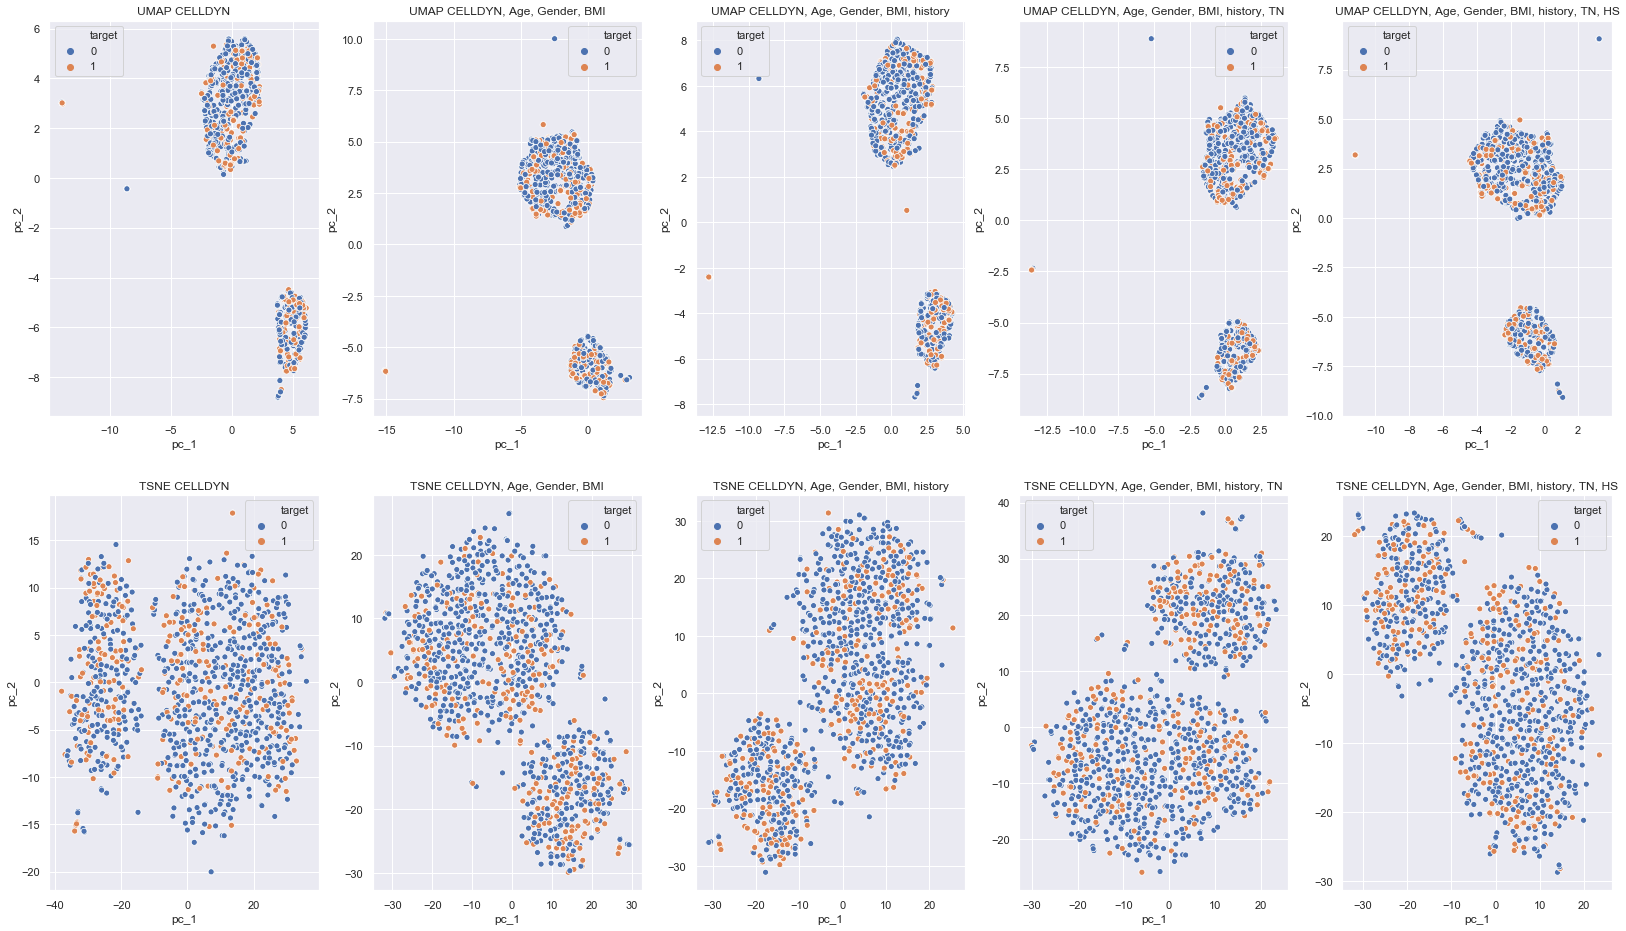

In [47]:
var_cols = get_var_cols(col_dict)
dat_viz['umap_celldyn'] = pd.DataFrame(data=um_celldyn.fit_transform(dat[col_dict['celldyn']]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI'];
dat_viz['umap_celldyn_plusAgeGenderBMI'] =  pd.DataFrame(data=um_other.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol'];
dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory'] = pd.DataFrame(data=um_ecg.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol', 'tn_admission'];
dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'] = pd.DataFrame(data=um_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol']+hs_cols;
dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'] = pd.DataFrame(data=um_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])


dat_viz['tsne_celldyn'] = pd.DataFrame(data=tsne_celldyn.fit_transform(dat[col_dict['celldyn']]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI'];
dat_viz['tsne_celldyn_plusAgeGenderBMI'] =  pd.DataFrame(data=tsne_other.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol'];
dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory'] = pd.DataFrame(data=tsne_ecg.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol', 'tn_admission'];
dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'] = pd.DataFrame(data=tsne_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol']+hs_cols;
dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'] = pd.DataFrame(data=tsne_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(28,16))
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI'], x='pc_1', y='pc_2', hue=y, ax=ax[0,1])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory'], x='pc_1', y='pc_2', hue=y, ax=ax[0,2])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'], x='pc_1', y='pc_2', hue=y, ax=ax[0,3])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'], x='pc_1', y='pc_2', hue=y, ax=ax[0,4])

ax[0,0].set_title('UMAP CELLDYN')
ax[0,1].set_title('UMAP CELLDYN, Age, Gender, BMI')
ax[0,2].set_title('UMAP CELLDYN, Age, Gender, BMI, history')
ax[0,3].set_title('UMAP CELLDYN, Age, Gender, BMI, history, TN')
ax[0,4].set_title('UMAP CELLDYN, Age, Gender, BMI, history, TN, HS')


sns.scatterplot(data=dat_viz['tsne_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[1,0])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI'], x='pc_1', y='pc_2', hue=y, ax=ax[1,1])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory'], x='pc_1', y='pc_2', hue=y, ax=ax[1,2])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'], x='pc_1', y='pc_2', hue=y, ax=ax[1,3])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'], x='pc_1', y='pc_2', hue=y, ax=ax[1,4])
ax[1,0].set_title('TSNE CELLDYN')
ax[1,1].set_title('TSNE CELLDYN, Age, Gender, BMI')
ax[1,2].set_title('TSNE CELLDYN, Age, Gender, BMI, history')
ax[1,3].set_title('TSNE CELLDYN, Age, Gender, BMI, history, TN')
ax[1,4].set_title('TSNE CELLDYN, Age, Gender, BMI, history, TN, HS')

Interestingly, including HS to the features hardly increases the visual separability of the targets.

Text(0.5, 1.0, 'TSNE CELLDYN, ECG, Age, Gender, BMI, history, TN, HS')

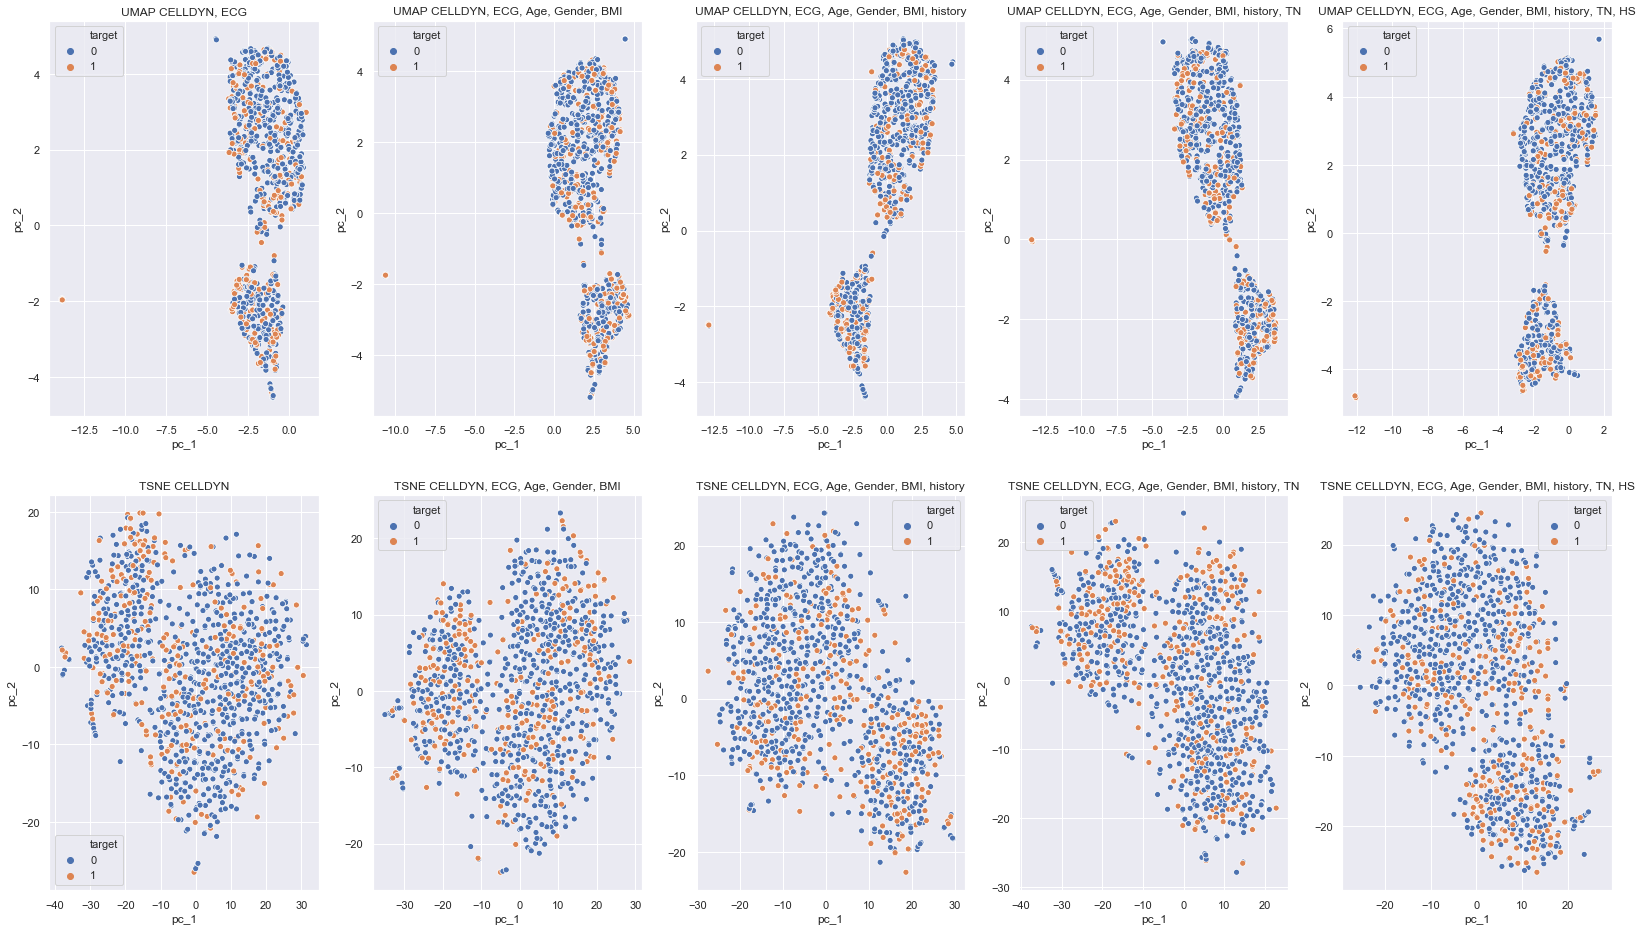

In [48]:
var_cols = get_var_cols(col_dict)
dat_viz['umap_celldyn'] = pd.DataFrame(data=um_celldyn.fit_transform(dat[col_dict['celldyn']+col_dict['ecg']]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+col_dict['ecg'];
dat_viz['umap_celldyn_plusAgeGenderBMI'] =  pd.DataFrame(data=um_other.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol']+col_dict['ecg'];
dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory'] = pd.DataFrame(data=um_ecg.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol', 'tn_admission']+col_dict['ecg'];
dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'] = pd.DataFrame(data=um_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol']+hs_cols+col_dict['ecg'];
dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'] = pd.DataFrame(data=um_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])


dat_viz['tsne_celldyn'] = pd.DataFrame(data=tsne_celldyn.fit_transform(dat[col_dict['celldyn']+col_dict['ecg']]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+col_dict['ecg'];
dat_viz['tsne_celldyn_plusAgeGenderBMI'] =  pd.DataFrame(data=tsne_other.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol']+col_dict['ecg'];
dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory'] = pd.DataFrame(data=tsne_ecg.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol', 'tn_admission']+col_dict['ecg'];
dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'] = pd.DataFrame(data=tsne_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])
_cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol']+hs_cols+col_dict['ecg'];
dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'] = pd.DataFrame(data=tsne_all.fit_transform(dat[_cols]), index=dat.index, columns=['pc_1', 'pc_2'])

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(28,16))
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI'], x='pc_1', y='pc_2', hue=y, ax=ax[0,1])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory'], x='pc_1', y='pc_2', hue=y, ax=ax[0,2])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'], x='pc_1', y='pc_2', hue=y, ax=ax[0,3])
sns.scatterplot(data=dat_viz['umap_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'], x='pc_1', y='pc_2', hue=y, ax=ax[0,4])

ax[0,0].set_title('UMAP CELLDYN, ECG')
ax[0,1].set_title('UMAP CELLDYN, ECG, Age, Gender, BMI')
ax[0,2].set_title('UMAP CELLDYN, ECG, Age, Gender, BMI, history')
ax[0,3].set_title('UMAP CELLDYN, ECG, Age, Gender, BMI, history, TN')
ax[0,4].set_title('UMAP CELLDYN, ECG, Age, Gender, BMI, history, TN, HS')


sns.scatterplot(data=dat_viz['tsne_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[1,0])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI'], x='pc_1', y='pc_2', hue=y, ax=ax[1,1])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory'], x='pc_1', y='pc_2', hue=y, ax=ax[1,2])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission'], x='pc_1', y='pc_2', hue=y, ax=ax[1,3])
sns.scatterplot(data=dat_viz['tsne_celldyn_plusAgeGenderBMI_plusHistory_plusTNadmission_plusHS'], x='pc_1', y='pc_2', hue=y, ax=ax[1,4])
ax[1,0].set_title('TSNE CELLDYN')
ax[1,1].set_title('TSNE CELLDYN, ECG, Age, Gender, BMI')
ax[1,2].set_title('TSNE CELLDYN, ECG, Age, Gender, BMI, history')
ax[1,3].set_title('TSNE CELLDYN, ECG, Age, Gender, BMI, history, TN')
ax[1,4].set_title('TSNE CELLDYN, ECG, Age, Gender, BMI, history, TN, HS')

# Supervised clustering

## UMAP

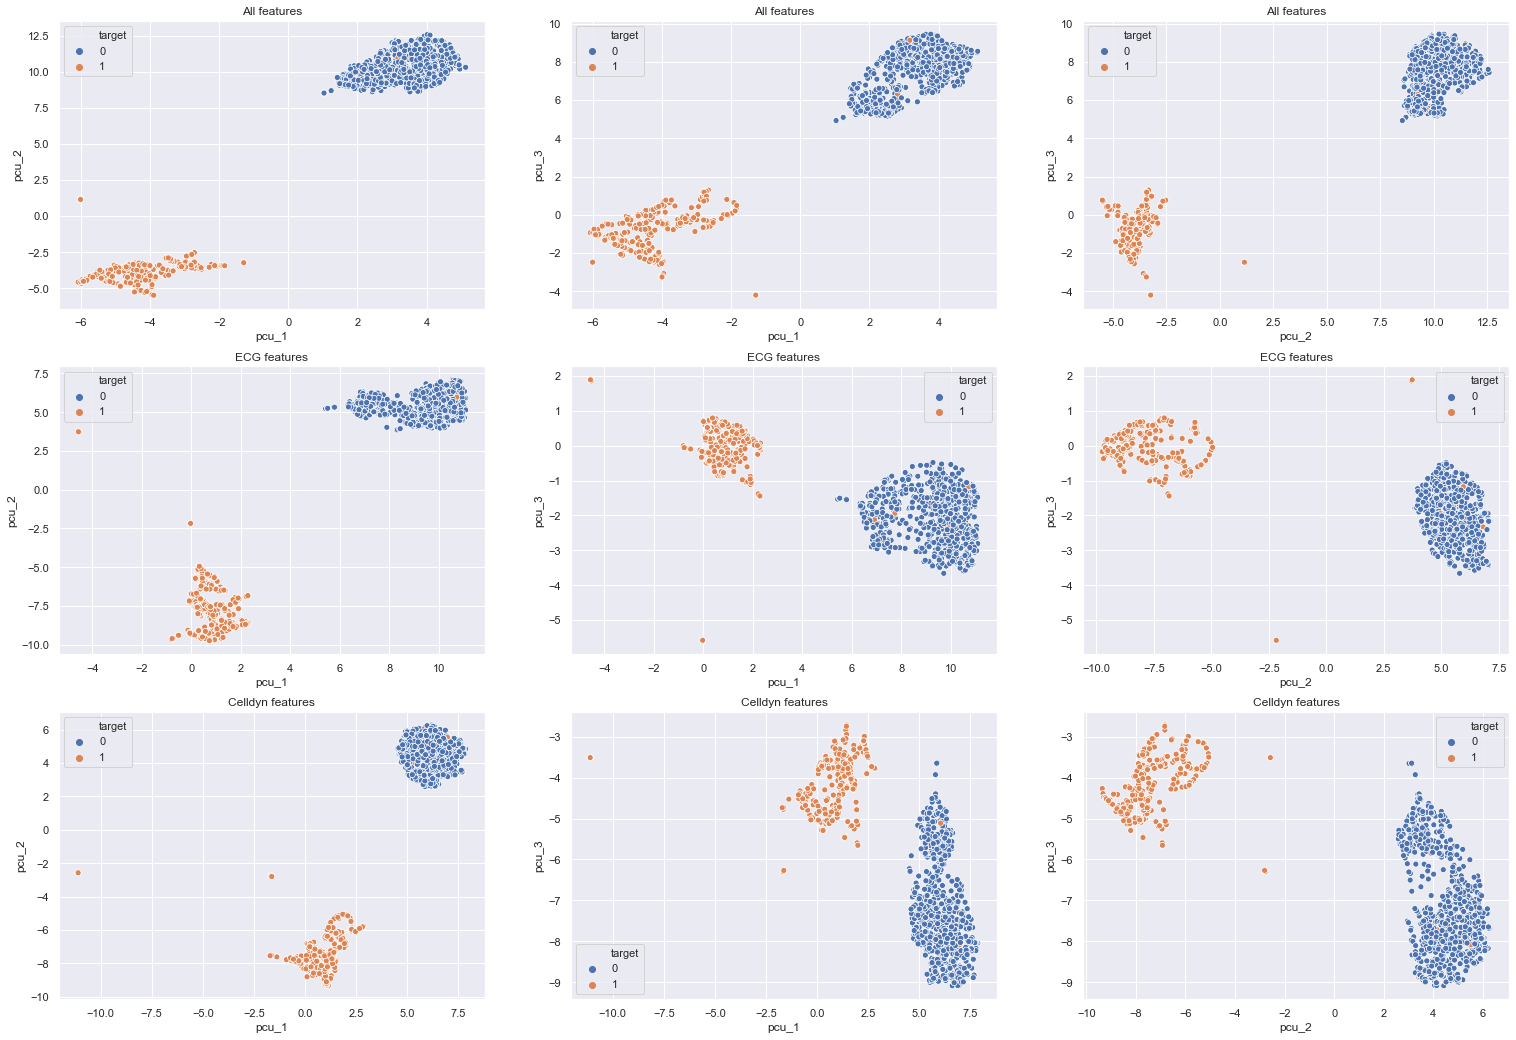

In [49]:
if run_supervised_umap:
    um_all_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
    dat_viz['umap_all_sup'] = pd.DataFrame(data=um_all_sup.fit_transform(dat[var_cols], 
                                                                 y=y), 
                                       index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

    um_ecg_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
    dat_viz['umap_ecg_sup'] = pd.DataFrame(data=um_ecg_sup.fit_transform(dat[var_cols], 
                                                                 y=y), 
                                       index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

    um_celldyn_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
    dat_viz['umap_celldyn_sup'] = pd.DataFrame(data=um_celldyn_sup.fit_transform(dat[var_cols], 
                                                                 y=y), 
                                       index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])
    
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(26,18))
    sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[0,0])
    sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[0,1])
    sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[0,2])

    sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[1,0])
    sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[1,1])
    sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[1,2])

    sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[2,0])
    sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[2,1])
    sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[2,2])

    ax[0,0].set_title('All features')
    ax[0,1].set_title('All features')
    ax[0,2].set_title('All features')

    ax[1,0].set_title('ECG features')
    ax[1,1].set_title('ECG features')
    ax[1,2].set_title('ECG features')

    ax[2,0].set_title('Celldyn features')
    ax[2,1].set_title('Celldyn features')
    ax[2,2].set_title('Celldyn features')

Supervised UMAP clustering seems to be well able to separate the targets. 

## PLS

In [50]:
pls_all_sup = PLS(n_components=2)
dat_viz['pls_all_sup'] = pd.DataFrame(data=pls_all_sup.fit_transform(dat[var_cols], 
                                                             y=y)[0], 
                                   index=dat.index, columns=['pls_1', 'pls_2'])

pls_ecg_sup = PLS(n_components=2)
dat_viz['pls_ecg_sup'] = pd.DataFrame(data=pls_ecg_sup.fit_transform(dat[col_dict['ecg']], 
                                                             y=y)[0], 
                                   index=dat.index, columns=['pls_1', 'pls_2'])

pls_celldyn_sup = PLS(n_components=2)
dat_viz['pls_celldyn_sup'] = pd.DataFrame(data=pls_celldyn_sup.fit_transform(dat[col_dict['celldyn']], 
                                                             y=y)[0], 
                                   index=dat.index, columns=['pls_1', 'pls_2'])

Text(0.5, 1.0, 'Celldyn features')

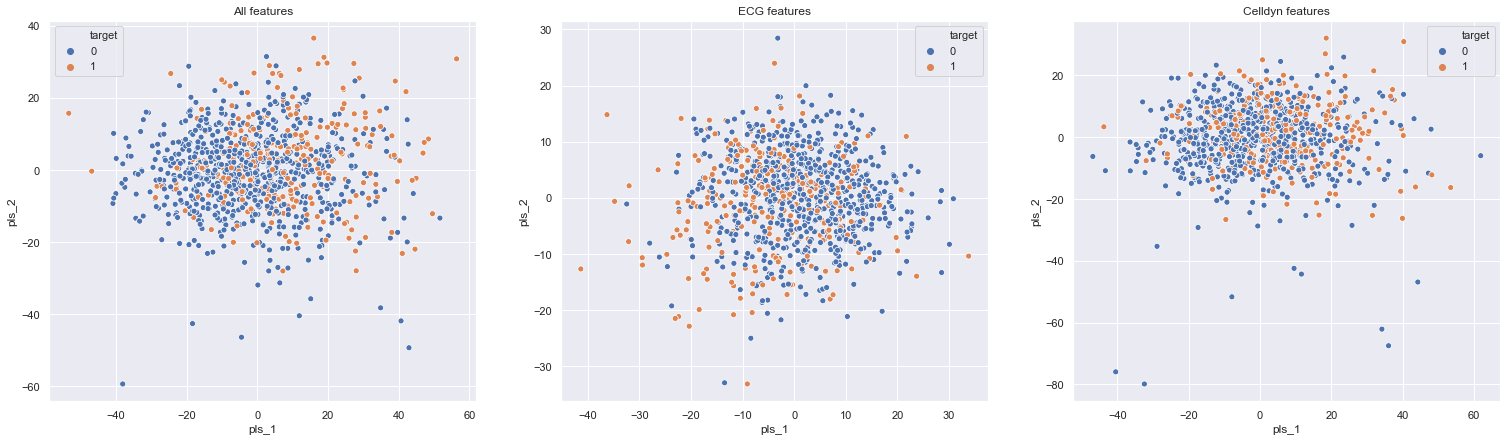

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(26,7))
sns.scatterplot(data=dat_viz['pls_all_sup'], x='pls_1', y='pls_2', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['pls_ecg_sup'], x='pls_1', y='pls_2', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['pls_celldyn_sup'], x='pls_1', y='pls_2', hue=y, ax=ax[2])

ax[0].set_title('All features')
ax[1].set_title('ECG features')
ax[2].set_title('Celldyn features')

## NCA

Text(0.5, 1.0, 'Celldyn features')

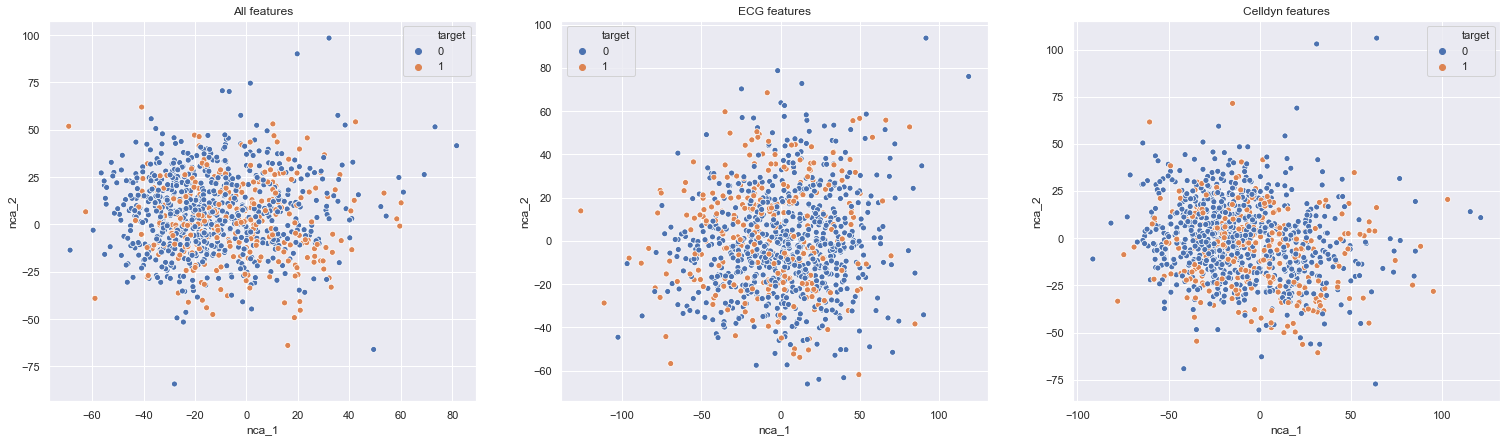

In [52]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
nca_sup = NCA(n_components=3, max_iter=100)
dat_viz['nca_all_sup'] = pd.DataFrame(data=nca_sup.fit_transform(dat[var_cols], 
                                                             y=y), 
                                   index=dat.index, columns=['nca_1', 'nca_2', 'nca_3'])
dat_viz['nca_ecg_sup'] = pd.DataFrame(data=nca_sup.fit_transform(dat[col_dict['ecg']], 
                                                             y=y), 
                                   index=dat.index, columns=['nca_1', 'nca_2', 'nca_3'])
dat_viz['nca_celldyn_sup'] = pd.DataFrame(data=nca_sup.fit_transform(dat[col_dict['celldyn']], 
                                                             y=y), 
                                   index=dat.index, columns=['nca_1', 'nca_2', 'nca_3'])

fig, ax = plt.subplots(ncols=3, figsize=(26,7))
sns.scatterplot(data=dat_viz['nca_all_sup'], x='nca_1', y='nca_2', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['nca_ecg_sup'], x='nca_1', y='nca_2', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['nca_celldyn_sup'], x='nca_1', y='nca_2', hue=y, ax=ax[2])

ax[0].set_title('All features')
ax[1].set_title('ECG features')
ax[2].set_title('Celldyn features')

## Cross-decomposition

**PLS, CCA** can be used to select informative combinations between feature sets, say between celldyn and ECG. 


# Linear separability using LDA

## ECG

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(484, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear ECG. 	 negative accuracy:0.9360967184801382, positive accuracy:0.5843230403800475


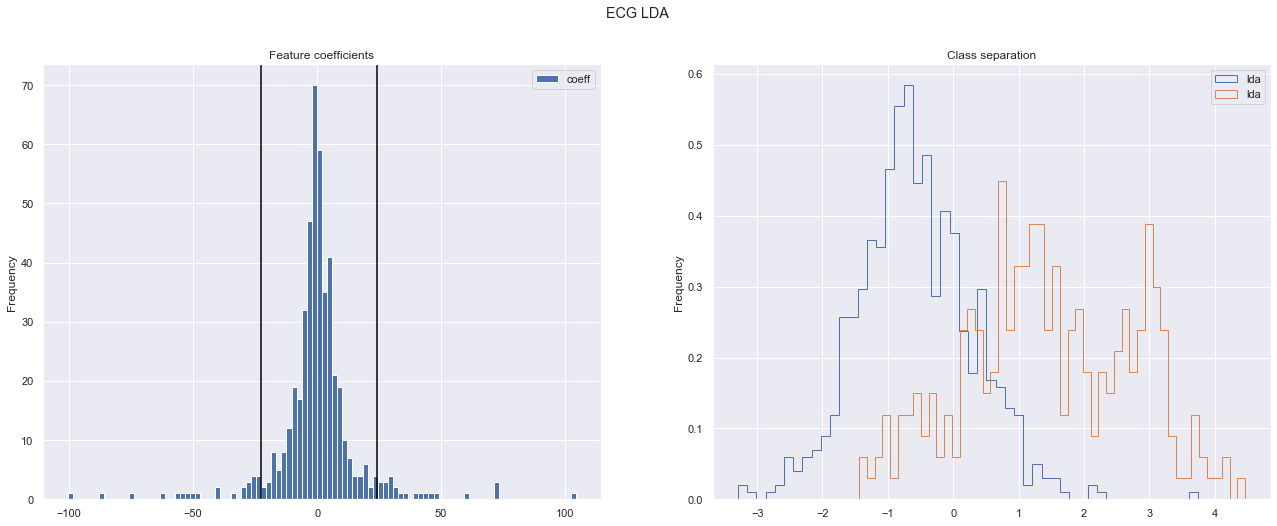

In [53]:
LDA_ecg = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_ecg.fit_transform(dat[col_dict['ecg']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_ecg.coef_[0], columns=['coeff'], index=col_dict['ecg'])

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('ECG LDA')

# strong linear separators
strong_separators_lda = dict()
strong_separators_lda['ecg'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0

neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear ECG. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Celldyn

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1440, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear CELLDYN. 	 negative accuracy:1.0, positive accuracy:0.9725085910652921


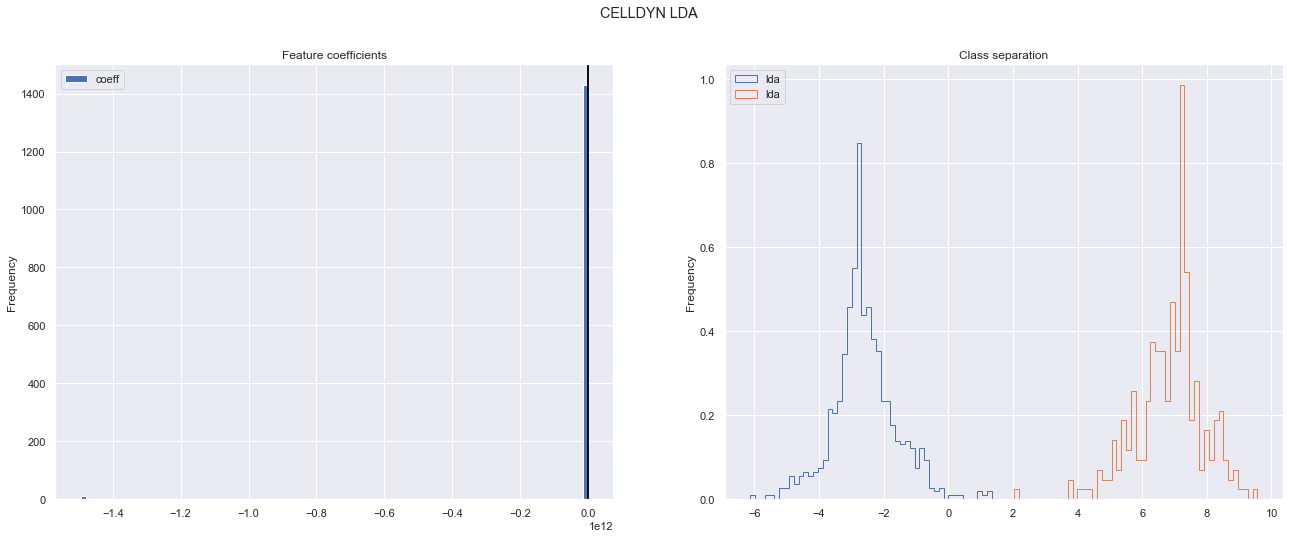

In [54]:
LDA_celldyn = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(dat[col_dict['celldyn']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=col_dict['celldyn'])

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, label='0', ax=ax[1])
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, label='1', ax=ax[1])
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('CELLDYN LDA')

# strong linear separators
strong_separators_lda['celldyn'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0.
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear CELLDYN. \t negative accuracy:{}, positive accuracy:{}'.format( neg , pos ))

There is a very clear separation between the two classes for the celldyn data which suggests that this data can be used to predict NSTEMI accurately. 

To verify this statement we have to split the data in a training set and a test set.

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2437, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


F1:0.3934426229508197, NPV:0.7611940298507462, ACC:0.5684523809523809, REC:(0.42857142857142855, 0.42857142857142855)


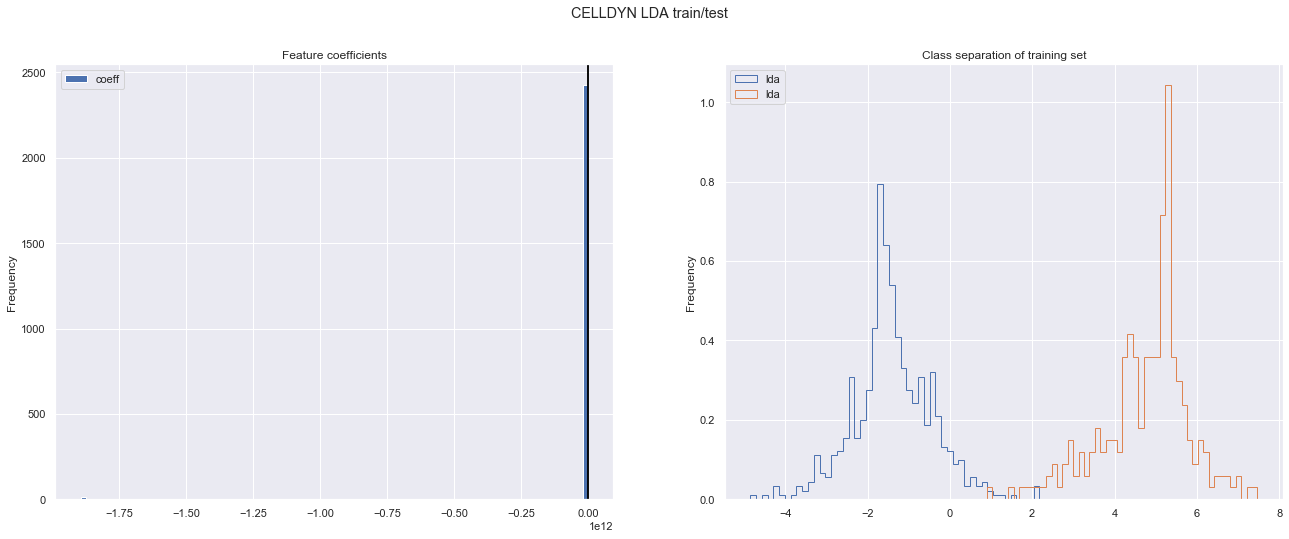

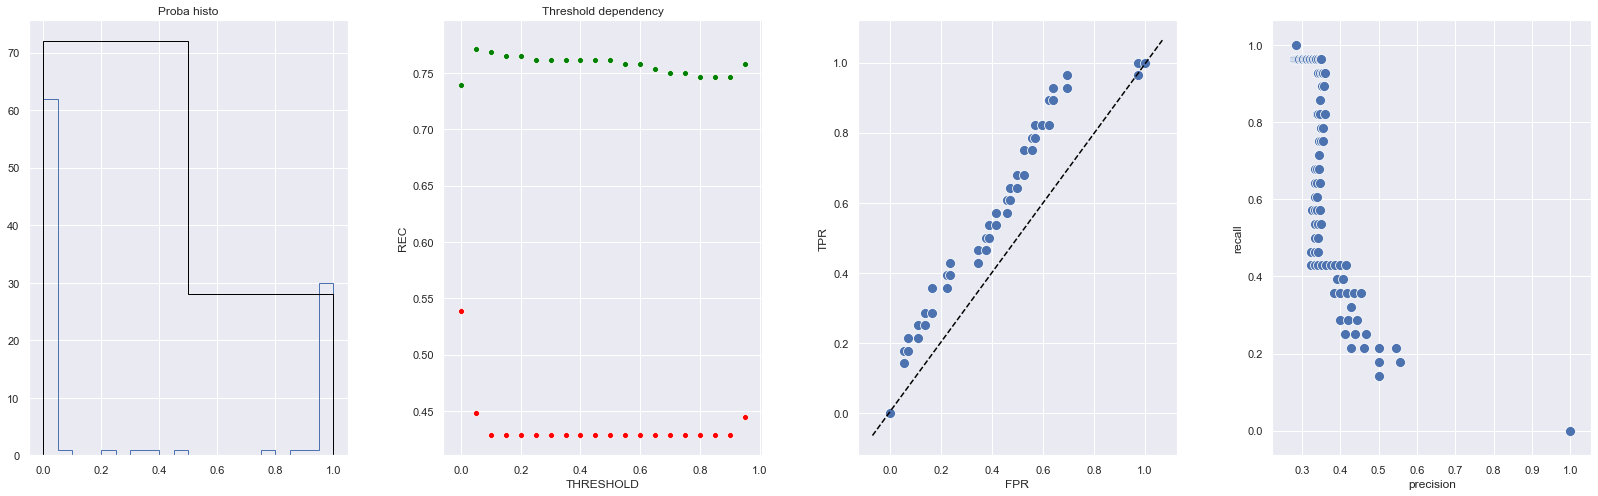

In [55]:
cols =  get_var_cols(col_dict)
LDA_celldyn = LDA(n_components=2, priors=[0.75, 0.25])
X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=None, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(X_train, y=y_train), columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y_train==0].plot.hist(bins=50, histtype='step', density=True, label='0', ax=ax[1])
lin_sep.loc[y_train==1].plot.hist(bins=50, histtype='step', density=True, label='1', ax=ax[1])
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation of training set')
plt.suptitle('CELLDYN LDA train/test')

y_pred = LDA_celldyn.predict_proba(X_test)[:,1]
_metrics = get_accuracy_plots(y_test, y_pred.copy());
print("F1:{}, NPV:{}, ACC:{}, REC:{}".format(fb_score(y_test, y_pred), npv(y_test, y_pred), balanced_accuracy(y_test, y_pred), recall(y_test, y_pred)))

The LDA separator generalises very poorly. According to literature (Friedman1989, Howland2003, Chen2000, etc.) the dimensionality of the LDA-processed data should be lower than the sample count to prevent singular scatter-matrices. To enforce this we can apply PCA to limit the number of dimensions to 90\% of the row-count.

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(225, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in double_scalars
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in double_scalars
c:\users\bes3\

F1:0.24390243902439027, NPV:0.735632183908046, ACC:0.5337301587301587, REC:(0.17857142857142858, 0.17857142857142858)


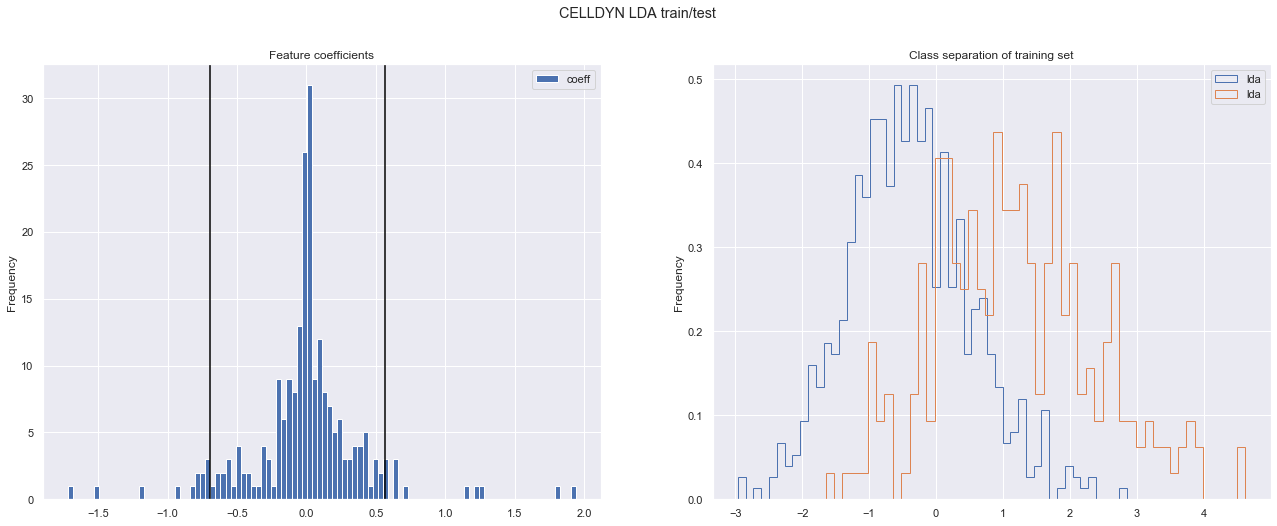

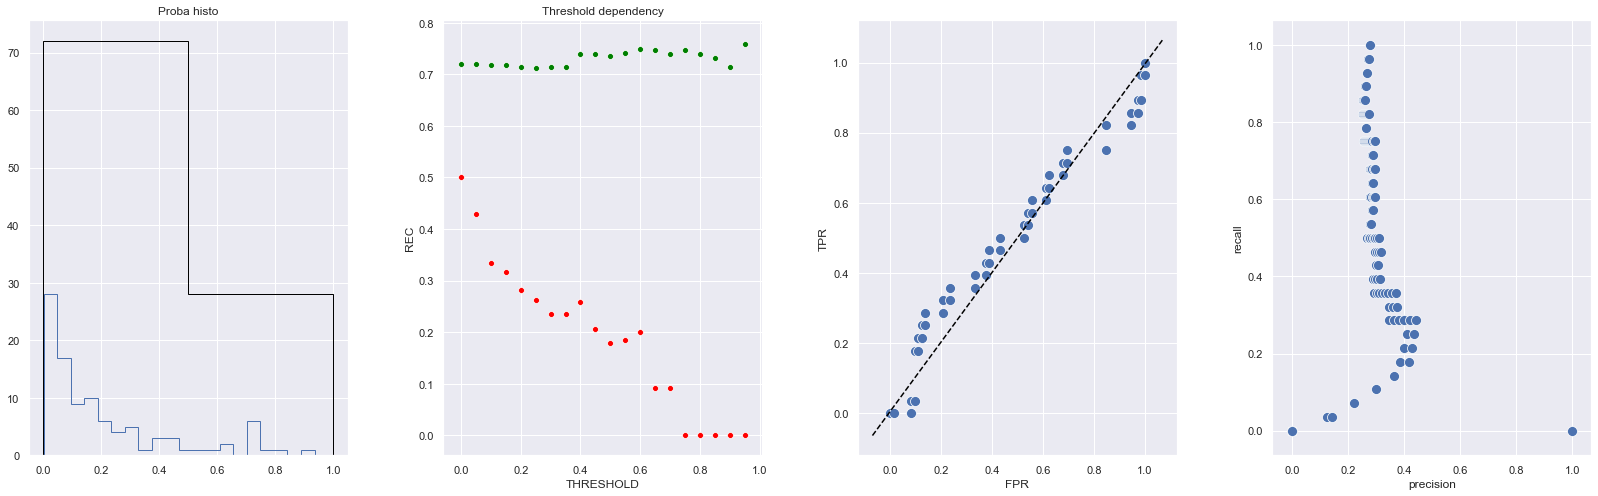

In [56]:
cols =  get_var_cols(col_dict)
red_perc = 0.25
LDA_celldyn = LDA(n_components=2, priors=[0.75, 0.25])
X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=None, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

if X_train.shape[1]>X_train.shape[0]:
    max_comp = np.int(red_perc*(X_train.shape[0]))
    cols = ['red_'+str(i) for i in range(0,max_comp)]
    _pca = PCA(n_components=max_comp)
    _pca.fit(X_train)
    X_train, X_test = _pca.transform(X_train), _pca.transform(X_test)

lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(X_train, y=y_train), columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y_train==0].plot.hist(bins=50, histtype='step', density=True, label='0', ax=ax[1])
lin_sep.loc[y_train==1].plot.hist(bins=50, histtype='step', density=True, label='1', ax=ax[1])
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation of training set')
plt.suptitle('CELLDYN LDA train/test')

y_pred = LDA_celldyn.predict_proba(X_test)[:,1]
_metrics = get_accuracy_plots(y_test, y_pred.copy());
print("F1:{}, NPV:{}, ACC:{}, REC:{}".format(fb_score(y_test, y_pred), npv(y_test, y_pred), balanced_accuracy(y_test, y_pred), recall(y_test, y_pred)))

Other aspects are:
* sensitivity of data to outliers (should be taken care of with quantile transformations)
* co-variance shift

## Other

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(29, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear Other. 	 negative accuracy:0.8561151079136691, positive accuracy:0.4572072072072072


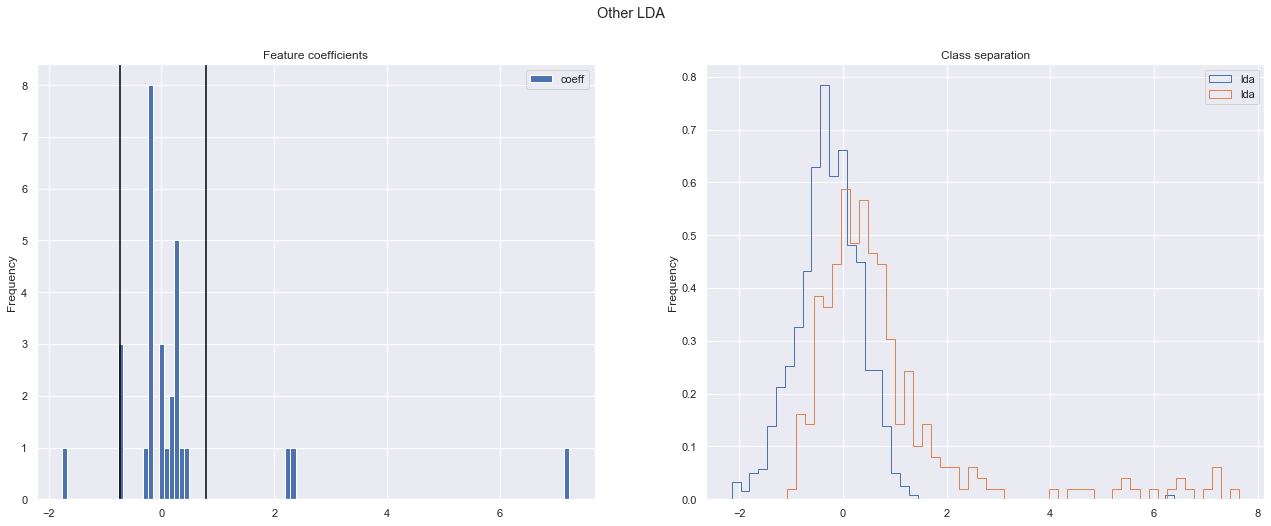

In [57]:
LDA_other = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(dat[col_dict['other']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=col_dict['other'])

q90 = coeff.quantile(0.9)[0]
q10 = coeff.quantile(0.1)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q90, color='black')
ax[0].axvline(q10, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('Other LDA')

# strong linear separators
strong_separators_lda['other'] = pd.concat([coeff.loc[coeff.coeff>q90], coeff.loc[coeff.coeff<q10]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear Other. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Combined



c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2437, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear all. 	 negative accuracy:1.0, positive accuracy:0.930921052631579


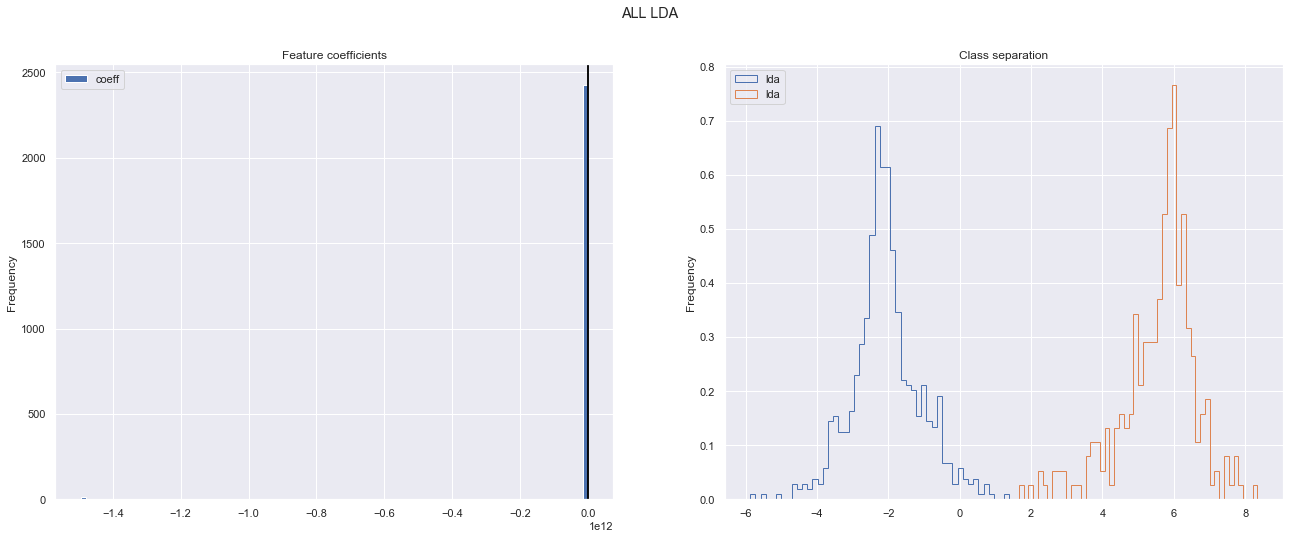

In [58]:
LDA_all = LDA(n_components=2)
var_cols = get_var_cols(col_dict)
lin_sep = pd.DataFrame(data=LDA_all.fit_transform(dat[var_cols], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_all.coef_[0], columns=['coeff'], index=var_cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('ALL LDA')

# strong linear separators
strong_separators_lda['combined'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear all. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## HeartScore

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(26, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear all. 	 negative accuracy:0.9214285714285715, positive accuracy:0.76


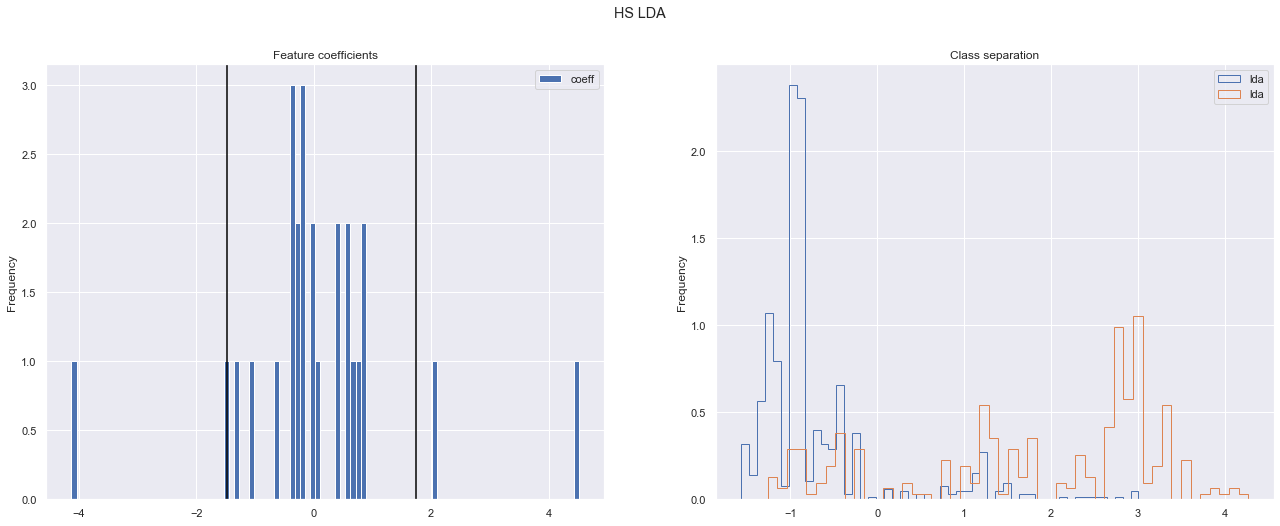

In [59]:
LDA_hs = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_hs.fit_transform(dat[hs_cols], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_hs.coef_[0], columns=['coeff'], index=hs_cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('HS LDA')

# strong linear separators
strong_separators_lda['hs'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear all. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Patient clustering

Using weighted correlation between the patient, where the weights are obtained from prior determined feature importances, say from LDA or PCA.

We can apply a pair-wise distance metric:
* KL-divergence
* cosine, euclidean etc.

Where it makes sense to include factor weights based on the separability.

Clustering options 
* Spectral clustering
* Hierchical clustering
* Louvain method (Fast community unfolding)
* Label propagation
* Walktrap community
* Edge betweenness community
* Leading eigenvector community
* Affinity propagation

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\pairwise.py:304: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\users\bes3\appdata\local\programs\python\python37\li

Mahalanobis values are not available


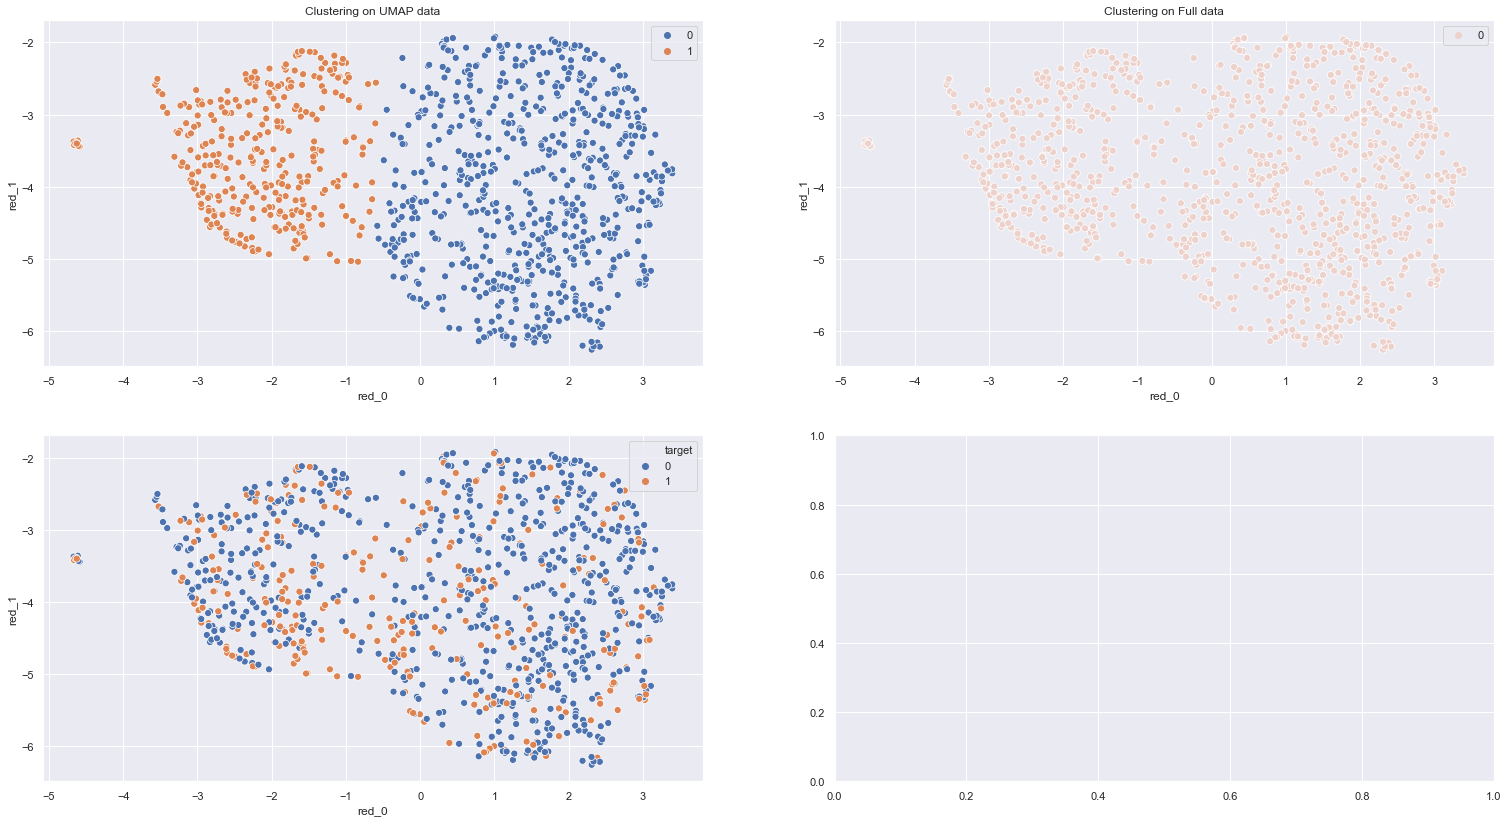

In [60]:
# Spectral clustering
n_comps = 2
nclust= 2
um_all = UMAP(n_components=n_comps, n_neighbors=15, min_dist=0.02)
red_data = pd.DataFrame(data=um_all.fit_transform(dat[var_cols]), columns=['red_'+str(k) for k in range(0, n_comps)], index=dat.index)

cluster_spectral = SpectralClustering(n_clusters=nclust, eigen_solver=None, n_components=nclust)
cluster_spectral.fit(red_data)
labs = cluster_spectral.labels_

cluster_spectral = SpectralClustering(n_clusters=nclust, eigen_solver=None, n_components=nclust)
cluster_spectral.fit(dat[var_cols])
labs_full = cluster_spectral.labels_

red_data['spectral_cluster_from_umap'] = labs
red_data['spectral_cluster_from_full'] = labs_full

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])

sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
try:
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
except Exception as e:
    print("Mahalanobis values are not available")
    
ax[0, 0].set_title('Clustering on UMAP data')
ax[0, 1].set_title('Clustering on Full data')

red_data = red_data.join(y)

Mahalanobis values are not available


Text(0.5, 1.0, 'Clustering on Full data')

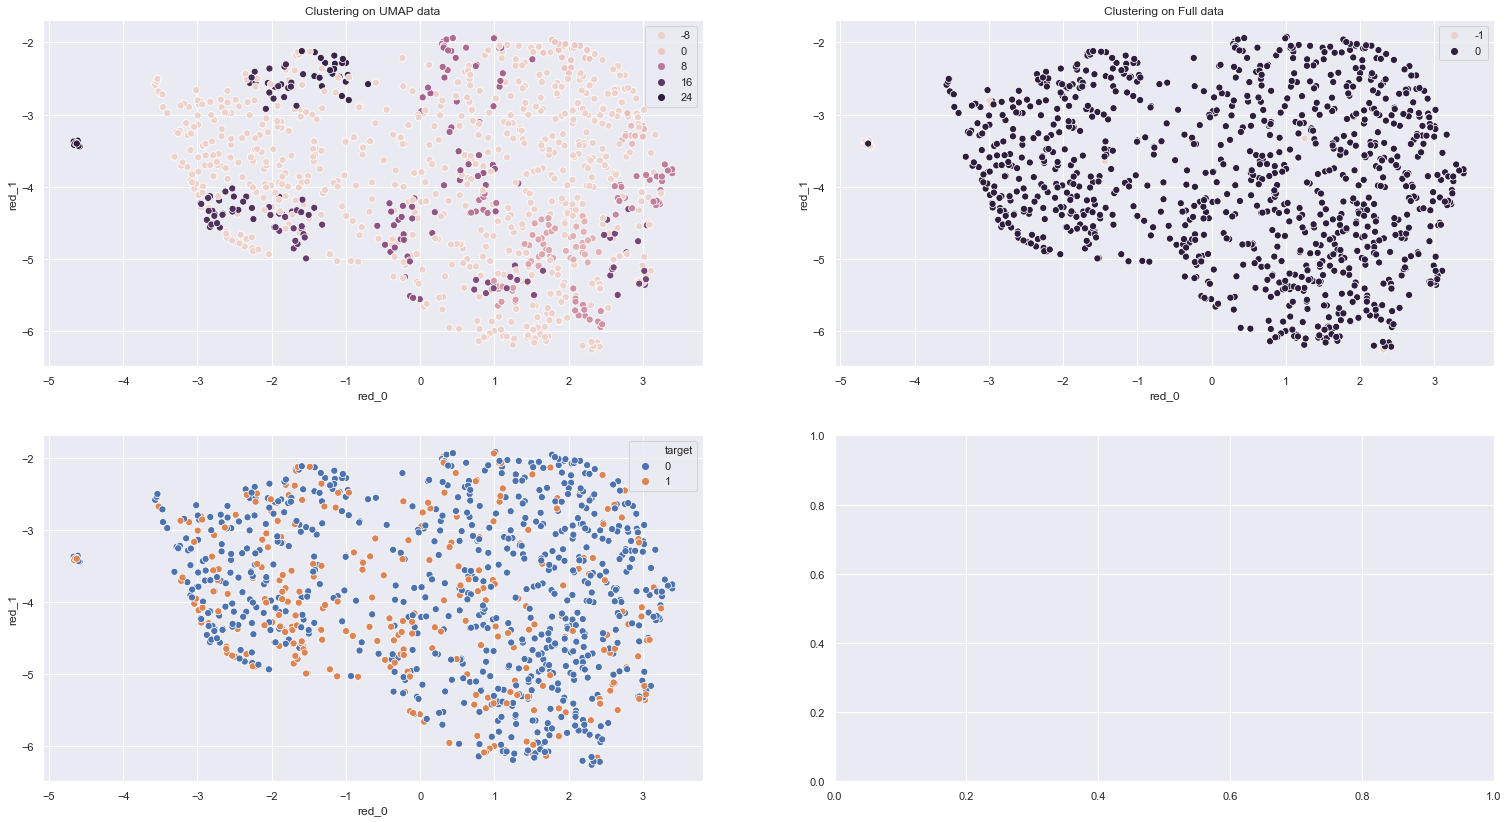

In [61]:
# OPTICS clustering
cluster_optics = OPTICS(min_samples=10, metric='minkowski', p=1)
cluster_optics.fit(red_data)
labs = cluster_optics.labels_

cluster_optics.fit(dat[var_cols])
labs_full = cluster_optics.labels_

red_data['optics_cluster_from_umap'] = labs
red_data['optics_cluster_from_full'] = labs_full

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
try:
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
except Exception as e:
    print("Mahalanobis values are not available")
    
ax[0, 0].set_title('Clustering on UMAP data')
ax[0, 1].set_title('Clustering on Full data')


Mahalanobis values are not available


Text(0.5, 1.0, 'Clustering on Full data')

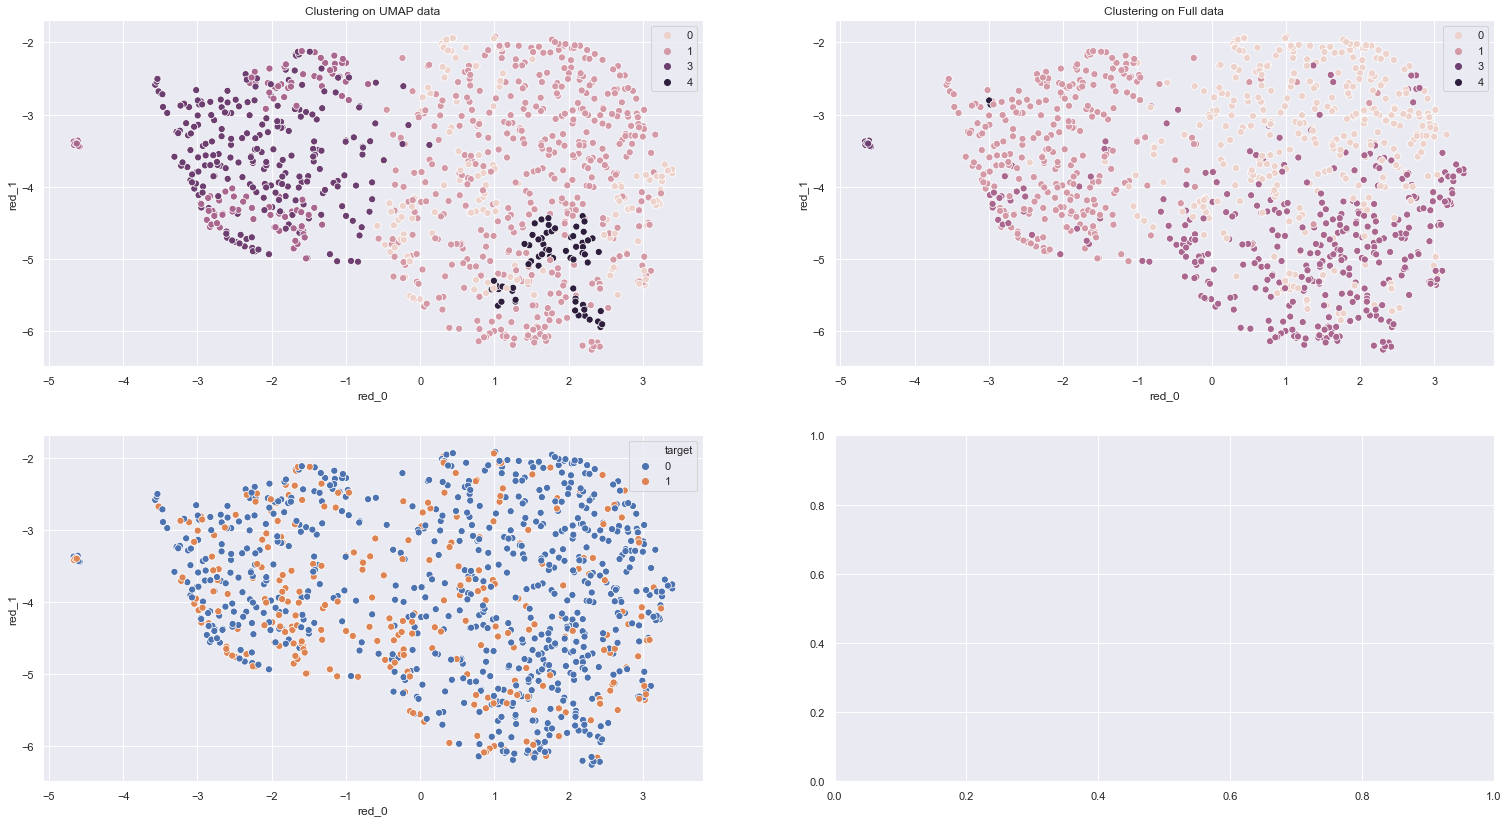

In [62]:
# Agglomerative clustering
cluster_agglo = AgglomerativeClustering(n_clusters=5, distance_threshold=None, affinity='euclidean')
cluster_agglo.fit(red_data)
labs = cluster_agglo.labels_

cluster_agglo.fit(dat[var_cols])
labs_full = cluster_agglo.labels_

red_data['agg_cluster_from_umap'] = labs
red_data['agg_cluster_from_full'] = labs_full

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])

sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
try:
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
except Exception as e:
    print("Mahalanobis values are not available")
ax[0, 0].set_title('Clustering on UMAP data')
ax[0, 1].set_title('Clustering on Full data')


## Hausdorff distance between sample groups
See the [wiki](https://en.wikipedia.org/wiki/Hausdorff_distance).

SciPy has a function readily available, see [directed Hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html), 
and more optimised version like a [Fast Hausdorff distance](https://github.com/mavillan/py-hausdorff).

One way to find patient clusters is to maximize the Hausdoff distance between patient groups.

Feature selection through Hausdorff distance: **Given the target groups, iteratively add features if the feature increases the Hausdorff distance between the target groups**  

# Supervised performance of mappers

In [63]:
col_dict['other'], hs_cols, tn_slope_cols

(['AGE',
  'RF_obese30',
  'gender',
  'RF_Smok',
  'BMI',
  'RF_HyperTens',
  'RF_CVDHist',
  'tn_admission',
  'RF_HyperChol',
  'RF_Diab',
  'RF_FamHist',
  'availdummy_PAxis_ECG',
  'availdummy_PAxis_ECG',
  'availdummy_POnset_ECG',
  'availdummy_PAxis_ECG_availdummy_POnset_ECG',
  'availdummy_POffset_ECG',
  'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG',
  'availdummy_P_RInterval_ECG',
  'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG',
  'availdummy_PAxis_ECG',
  'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG_availdummy_PAxis_ECG',
  'availdummy_POffset_ECG',
  'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG_availdummy_PAxis_ECG_availdummy_POffset_ECG',
  'availdummy_POnset_ECG',
  'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG_availdummy_PAxis_ECG_availdummy_POffset_ECG_avai

In [64]:
cols = col_dict['celldyn']+['AGE', 'BMI', 'gender']+['tn_admission']+['RF_FamHist', 'RF_Smok', 'RF_HyperChol', 'RF_obese30', 'RF_Diab', 'RF_HyperTens','RF_CVDHist']+col_dict['ecg']
#get_var_cols(col_dict) #, col_dict['celldyn'], col_dict['ecg'], col_dict['other'], hs_cols

## UMAP

0.68 0.2727272727272727 0.5400679941719281


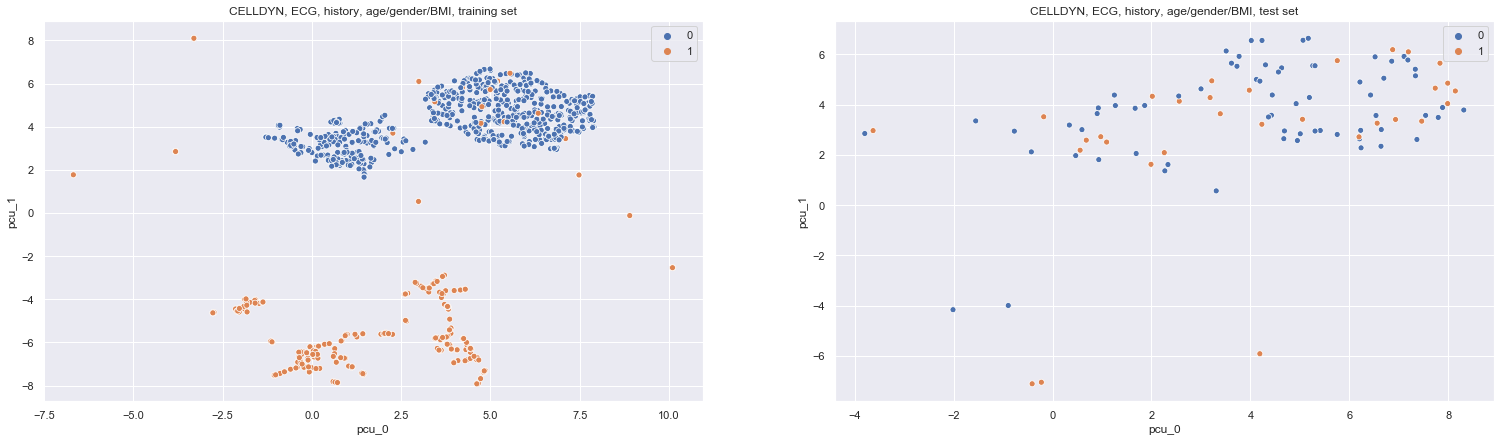

In [65]:
run_supervised_umap = True
n_comps_viz = 2
n_comps_class = 7
if run_supervised_umap:
    X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=89)
    if remove_outlying_samples_from_test:
        iso = IsolationForest(n_estimators=400, n_jobs=4)
        iso.fit(X_train)
        out_in = iso.predict(X_test)
        X_test = X_test[np.where(out_in==1),:]
        y_test = y_test[np.where(out_in==1)]


    umap = UMAP(n_components=n_comps_viz, n_neighbors=7, min_dist=0.07)
    umap.fit(X_train, y_train)

    red_cols = ['pcu_'+str(k) for k in range(0,n_comps_viz)]
    train_transform = pd.DataFrame(data=umap.transform(X_train), columns=red_cols)
    test_transform = pd.DataFrame(data=umap.transform(X_test), columns=red_cols)

    fig, ax = plt.subplots(ncols=2, figsize=(26,7))
    sns.scatterplot(data=train_transform, x='pcu_0', y='pcu_1', hue=y_train.values, ax=ax[0])
    sns.scatterplot(data=test_transform, x='pcu_0', y='pcu_1', hue=y_test.values, ax=ax[1])
    ax[0].set_title('CELLDYN, ECG, history, age/gender/BMI, training set')
    ax[1].set_title('CELLDYN, ECG, history, age/gender/BMI, test set')
    
     # get_var_cols(col_dict)
    cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol', 'tn_admission']#+hs_cols+col_dict['ecg'];
    clf = KNeighborsClassifier(n_neighbors=20, metric='minkowski', p=1)
    X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=None)
    umap = UMAP(n_components=n_comps_class, n_neighbors=7, min_dist=0.07)
    umap.fit(X_train, y_train)

    train_transform = umap.transform(X_train)
    test_transform = umap.transform(X_test)

    clf.fit(train_transform, y_train)
    y_pred = clf.predict(test_transform)

    print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

Using CELLDYN data plus meta information and clinically available information we see that the supervised embedding generalises rather poorly. We expect that with more data this generalisation improves.

## SOM

SuSi: [paper](https://arxiv.org/abs/1903.11114), [code](https://github.com/felixriese/susi)

-- SOM fitted --


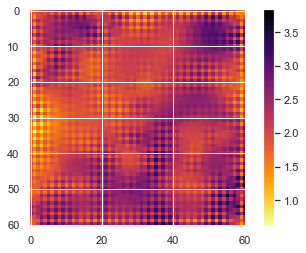

0.51 0.3636363636363636 0.4939223936418887


In [66]:
import susi

X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=89)

cclf = susi.SOMClustering(n_rows=31, n_columns=31)
cclf.fit(dat[cols].values)
print("-- SOM fitted --")

u_matrix = cclf.get_u_matrix()
plt.imshow(np.squeeze(u_matrix), cmap="inferno_r")
plt.colorbar()
plt.show()

clf = susi.SOMClassifier(n_rows=61,
                         n_columns=61,
                         n_iter_unsupervised=5000,
                         n_iter_supervised=5000,
                         random_state=0)
clf.fit(X_train, y_train.astype(np.int32))

y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

## LVQ

In [67]:
from neupy import algorithms

# reduce
red = UMAP(n_components=40, n_neighbors=30, min_dist=0.01)
#red = PCA(n_components=30)
red.fit(X_train)
X_train = red.transform(X_train)
X_test = red.transform(X_test)


clf = algorithms.LVQ(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
clf.train(X_train, y_train, epochs=500)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

clf = algorithms.LVQ21(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
clf.train(X_train, y_train, epochs=500)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

clf = algorithms.LVQ3(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
clf.train(X_train, y_train, epochs=500)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

0.64 0.0 0.463768115942029


0.68 0.0 0.4927536231884058


c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numpy\linalg\linalg.py:2507: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numpy\linalg\linalg.py:2506: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\neupy\algorithms\competitive\lvq.py:564: RuntimeWarning: overflow encountered in subtract
  weight[top1_subclass, :] -= step * top1_weight_update


0.69 0.0 0.5


Learning vector quantisation is clearly not able to separate the classses, we can possibly improve this model using parameter tuning but that is beyond the scope of this work.

# Supervised classifiers

In [68]:
scores = dict()
model = dict()

## LDA

In [69]:
clf = LDA()
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'f1_micro': 'f1_micro',
           'prec_macro': 'precision_macro', 
           'prec_micro': 'precision_micro',
           'rec_macro': make_scorer(recall_score, average='macro'),
           'rec_micro': make_scorer(recall_score, average='micro')}
scores['LDA'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['LDA'] = clf

## LR

In [70]:
clf = LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')
scores['LR'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['LR'] = clf

## RF

In [71]:
clf = RandomForestClassifier(n_estimators=200)
scores['RF'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['RF'] = clf

## nuSVM

In [72]:
clf = NuSVC(nu=0.5)
scores['SVC'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['SVC'] = clf

## MLP

In [73]:
clf = MLPClassifier(hidden_layer_sizes=(100,50,25), max_iter=200, learning_rate_init=0.005, learning_rate='adaptive')
scores['MLP'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['MLP'] = clf

## Ensembling
We combine: RF+nuSVM+LR+LDA.

In [74]:
clfs = [('RF', RandomForestClassifier(n_estimators=200)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scores['ensemble_vote'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote'] = clf

In [75]:
clf = BaggingClassifier(base_estimator=LogisticRegression(max_iter=500, solver='liblinear'), n_estimators=5)

scores['ensemble_bag'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, 
                                                    scoring=scoring, 
                                                     cv=10, return_train_score=True))
model['ensemble_bag'] = clf

In [76]:
# HS
clfs = [('RF', RandomForestClassifier(n_estimators=50)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(40,30,20), 
                              max_iter=200, learning_rate_init=0.002, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scores['ensemble_vote_hs'] = pd.DataFrame(cross_validate(clf, dat[hs_cols].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_hs'] = clf

In [77]:
# tn_slope_cols
clfs = [('RF', RandomForestClassifier(n_estimators=25)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(30,20,10), 
                              max_iter=200, learning_rate_init=0.002, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scores['ensemble_vote_slope'] = pd.DataFrame(cross_validate(clf, dat[tn_slope_cols].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_slope'] = clf

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [78]:
# celldyn
clfs = [('RF', RandomForestClassifier(n_estimators=300)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(50,30,30), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scores['ensemble_vote_celldyn'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_celldyn'] = clf

In [79]:
# celldyn+age+sex+BMI+troponine
clfs = [('RF', RandomForestClassifier(n_estimators=200)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

ex_feat = ['AGE', 'gender', 'tn_admission']
scores['ensemble_vote_celldyn_plusMeta'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']+ex_feat].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_celldyn_plusMeta'] = clf

In [80]:
# celldyn+age+sex+BMI+troponine+ECG
clfs = [('RF', RandomForestClassifier(n_estimators=400)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

ex_feat = ['AGE', 'gender', 'tn_admission']+col_dict['ecg']
scores['ensemble_vote_celldyn_plusMeta_plusECG'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']+ex_feat].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_celldyn_plusMeta_plusECG'] = clf

In [81]:
clf = EBM()

ex_feat = ['AGE', 'gender', 'BMI']+col_dict['ecg']
X = dat[col_dict['celldyn']+ex_feat].values
X = MinMaxScaler().fit_transform(X)

scores['EBM_celldyn_plusMeta_plusECG'] = pd.DataFrame(cross_validate(clf, X, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['EBM_celldyn_plusMeta_plusECG'] = clf
scores['EBM_celldyn_plusMeta_plusECG'].mean()

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time                   23.320260
score_time                  0.301080
test_auc                    0.629949
train_auc                   0.966119
test_balanced_accuracy      0.515274
train_balanced_accuracy     0.668810
test_f1_macro               0.465738
train_f1_macro              0.692469
test_f1_micro               0.713000
train_f1_micro              0.812556
test_prec_macro             0.561459
train_prec_macro            0.896573
test_prec_micro             0.713000
train_prec_micro            0.812556
test_rec_macro              0.515274
train_rec_macro             0.668810
test_rec_micro              0.713000
train_rec_micro             0.812556
dtype: float64

In [82]:
clf = XGB()

ex_feat = ['AGE', 'gender', 'tn_admission']+col_dict['ecg']
scores['XGB_celldyn_plusMeta_plusECG'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']+ex_feat].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['XGB_celldyn_plusMeta_plusECG'] = clf
scores['XGB_celldyn_plusMeta_plusECG'].mean()

fit_time                   9.712020
score_time                 0.014040
test_auc                   0.902131
train_auc                  0.999972
test_balanced_accuracy     0.837945
train_balanced_accuracy    0.992146
test_f1_macro              0.848576
train_f1_macro             0.994495
test_f1_micro              0.881000
train_f1_micro             0.995556
test_prec_macro            0.864721
train_prec_macro           0.996922
test_prec_micro            0.881000
train_prec_micro           0.995556
test_rec_macro             0.837945
train_rec_macro            0.992146
test_rec_micro             0.881000
train_rec_micro            0.995556
dtype: float64

In [83]:
clf = LGBM()

ex_feat = ['AGE', 'gender', 'tn_admission']+col_dict['ecg']
scores['LGBM_celldyn_plusMeta_plusECG'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']+ex_feat].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['LGBM_celldyn_plusMeta_plusECG'] = clf
scores['LGBM_celldyn_plusMeta_plusECG'].mean()

fit_time                   19.873260
score_time                  0.010920
test_auc                    0.897485
train_auc                   1.000000
test_balanced_accuracy      0.829244
train_balanced_accuracy     1.000000
test_f1_macro               0.845608
train_f1_macro              1.000000
test_f1_micro               0.881000
train_f1_micro              1.000000
test_prec_macro             0.872142
train_prec_macro            1.000000
test_prec_micro             0.881000
train_prec_micro            1.000000
test_rec_macro              0.829244
train_rec_macro             1.000000
test_rec_micro              0.881000
train_rec_micro             1.000000
dtype: float64

In [243]:
## add simple CNN 
import keras.backend as K

# keras
#def dice_coef(y_true, y_pred, smooth, thresh):
#    y_pred = K.cast((y_pred > thresh), dtype='float32')
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef(y_true, y_pred, smooth):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)    
    
    
# keras
def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred, smooth=1e-5) #  thresh=0.5

#dice_loss_model = dice_loss()


def simple_1dcnn(dims=None, conv_layers=[(48,6,3), (48,6,1), (48,6,3)], init_dropout=0.5, final_dropout=0.5):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, 1)))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Conv1D(_l[0], _l[1]))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=_l[2]))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(final_dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_loss])
    
    return model

def simple_dnn(dims=None, conv_layers=[(128,0.05), (64,0.05), (32,0.05)], init_dropout=0.25, final_dropout=0.5):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, )))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Dense(_l[0], activation='relu'))
        model.add(Dropout(_l[1]))
        
    model.add(Dropout(final_dropout))    
    model.add(Dense(1,  activation='sigmoid'))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', dice_loss])     # 'binary_crossentropy'     
    return model

def _transform(x, trans='minmax', n_quantiles=250, distr='uniform', reducer='PCA', n_comp=128):
    if trans=='minmax':
        mm = MinMaxScaler()
        x = mm.fit_transform(x)
    elif trans=='quantile':
        mm = QuantileTransformer(n_quantiles=n_quantiles, output_distribution=distr)
        x = mm.fit_transform(x)  
    else:
        mm = None
    if reducer=='PCA':
        reducer = PCA(n_components=n_comp)
        x = reducer.fit_transform(x)
    return x, [mm , reducer]
    
def fit_nn(X, y, network='dnn', verbose=0, epochs=20, batch_size=100, class_weight=None):
    if network == 'cnn':
        X = np.expand_dims(X, 2)
        clf = simple_1dcnn(dims=X.shape)
    else:
        clf = simple_dnn(dims=X.shape)
    clf.fit(X, y, batch_size = batch_size, epochs = epochs, verbose = verbose, class_weight = class_weight)
    return clf

class_weights = {0: 1., 1: 3.}

X = dat[cols].values
X = _transform(X, trans='quantile')[0]
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1, stratify=y.values)
clf = fit_nn(X_train, y_train, network='dnn', verbose=0, batch_size=250, epochs=100, class_weight=class_weights)
y_pred = clf.predict(X_test)

print("Same transformer..Balanced accuracy: {}, F1 score: {}, ROC AUC: {}".format(balanced_accuracy(y_test, np.round(y_pred[:,0])), 
                                                            fb_score(y_test, np.round(y_pred[:,0])),
                                                            metrics.roc_auc_score(y_test, y_pred[:,0])))


Same transformer..Balanced accuracy: 0.5873015873015872, F1 score: 0.43478260869565216, ROC AUC: 0.6140873015873016


<<DNN>> Train transformer..Balanced accuracy: 0.7341269841269842, F1 score: 0.6181818181818182, ROC AUC: 0.8120039682539683


Text(0.5, 1.0, 'Pseudo-probas')

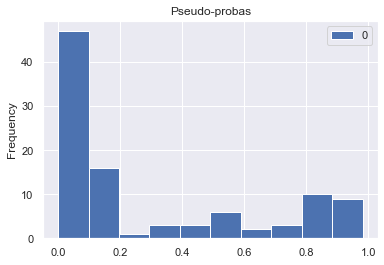

In [85]:
# repeat for train transformer applied to test.
class_weights = {0: 1., 1: 2.}
X = dat[cols].values
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1, stratify=y.values)
X_train, _transformers = _transform(X_train, trans='quantile')
X_test = X_test if _transformers is None else _transformers[1].transform(_transformers[0].transform(X_test))

clf = fit_nn(X_train, y_train, network='dnn', verbose=0, batch_size=750, epochs=150, class_weight=class_weights)
y_pred = clf.predict(X_test)

print("<<DNN>> Train transformer..Balanced accuracy: {}, F1 score: {}, ROC AUC: {}".format(balanced_accuracy(y_test, np.round(y_pred[:,0])), 
                                                            fb_score(y_test, np.round(y_pred[:,0])),
                                                            metrics.roc_auc_score(y_test, y_pred[:,0])))
pd.DataFrame(y_pred[:, 0]).plot.hist(bins=10)
plt.title('Pseudo-probas')

<<CNN>> Train transformer..Balanced accuracy: 0.7103174603174603, F1 score: 0.5806451612903226, ROC AUC: 0.808531746031746


Text(0.5, 1.0, 'Pseudo-probas')

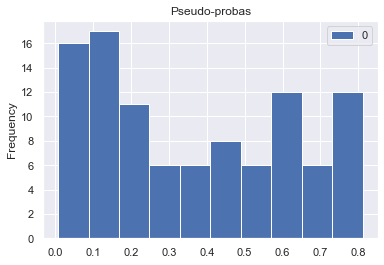

In [86]:
# repeat for train transformer applied to test.
class_weights = {0: 1., 1: 2.}
X = dat[cols].values
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1, stratify=y.values)
X_train, _transformers = _transform(X_train, trans='quantile')
X_test = X_test if _transformers is None else _transformers[1].transform(_transformers[0].transform(X_test))


clf = fit_nn(X_train, y_train, network='cnn', verbose=0, batch_size=100, epochs=250, class_weight=class_weights)
X_test = np.expand_dims(X_test, 2)
y_pred = clf.predict(X_test)

print("<<CNN>> Train transformer..Balanced accuracy: {}, F1 score: {}, ROC AUC: {}".format(balanced_accuracy(y_test, np.round(y_pred[:,0])), 
                                                            fb_score(y_test, np.round(y_pred[:,0])),
                                                            metrics.roc_auc_score(y_test, y_pred[:,0])))
pd.DataFrame(y_pred[:, 0]).plot.hist(bins=10)
plt.title('Pseudo-probas')

It seems that both the dense and the convolutional networks perform reasonably well on this problem,
again this can possibly be improved with parameter tuning but this is beyond the scope of this work.

## Summary of exploratory classification 

In [87]:
for idx, _mod in enumerate(scores.keys()):
    if idx==0:
        df = scores[_mod].mean().transpose()
    else:
        df = pd.concat([df, scores[_mod].mean()], axis=1)
df.columns = list(scores.keys())
df.drop(['fit_time', 'score_time'], axis=0, inplace=True)
df = df.transpose()
df.reset_index(inplace=True)
df.sort_values(by='test_auc', inplace=True)

Text(0.5, 0, '')

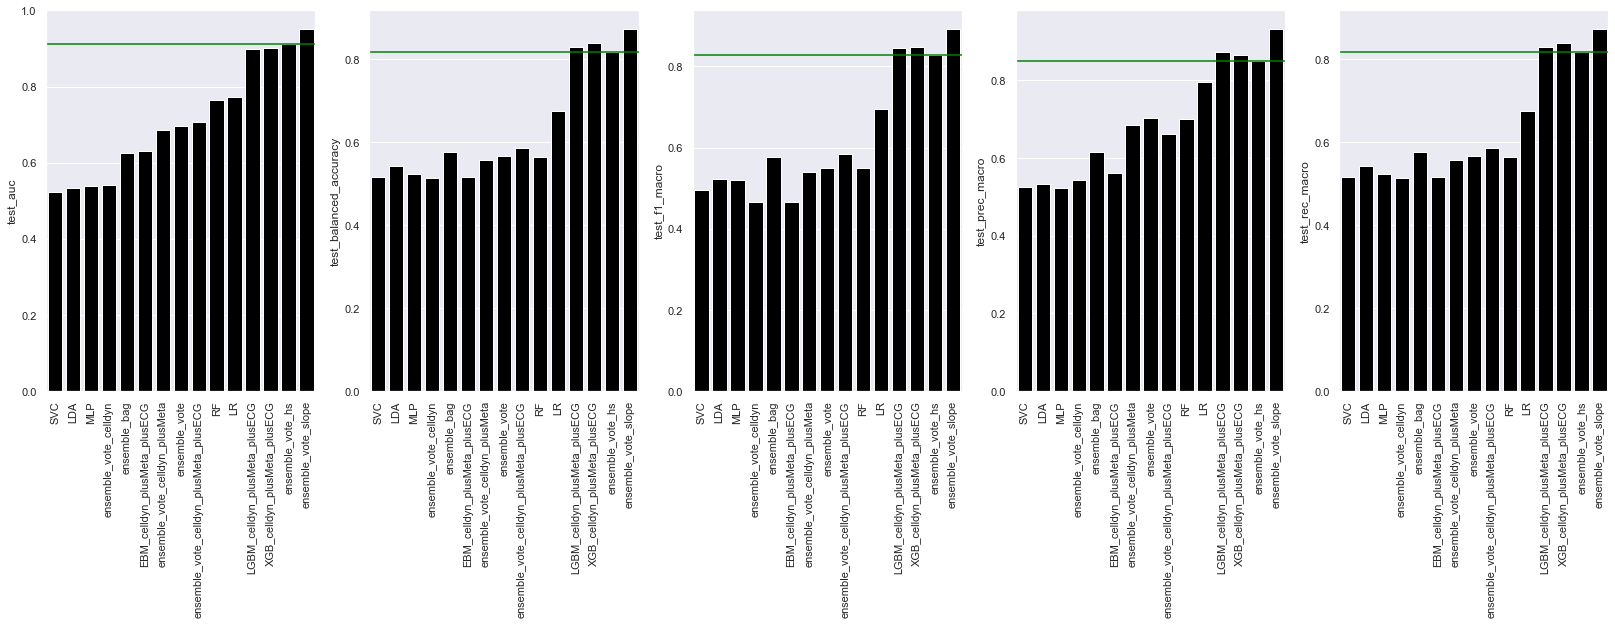

In [88]:
fig, ax = plt.subplots(ncols=5, figsize=(28, 7))

sns.barplot(data=df, x='index', y='test_auc', ax=ax[0], color='black')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_auc'].values[0], color='green')

sns.barplot(data=df, x='index', y='test_balanced_accuracy', ax=ax[1], color='black')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_balanced_accuracy'].values[0], color='green')

sns.barplot(data=df, x='index', y='test_f1_macro', ax=ax[2], color='black')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[2].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_f1_macro'].values[0], color='green')

sns.barplot(data=df, x='index', y='test_prec_macro', ax=ax[3], color='black')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=90)
ax[3].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_prec_macro'].values[0], color='green')

sns.barplot(data=df, x='index', y='test_rec_macro', ax=ax[4], color='black')
ax[4].set_xticklabels(ax[4].get_xticklabels(), rotation=90)
ax[4].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_rec_macro'].values[0], color='green')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
ax[4].set_xlabel('')

# Final scoring 

We have the following setup's
* Celldyn 
* Celldyn, age, sex, BMI
* Celldyn, age, sex, BMI, ECG
* (Celldyn, age, sex, BMI, ECG, troponine) - (age, sex, BMI, ECG, troponine)
* reference: Celldyn, age, sex, BMI, ECG, troponine, history
* reference: Celldyn, age, sex, BMI, ECG, troponine, history + HS

**Deliverable**: comparison between datasets in terms of statistical distance between classes/importance of features.

For each setup we obtain the 

1. ROC curves
2. threshold v. recall/precision/F1/true recall
3. threshold v. FN/FP/recall/true recall

Models: XGB, LGBM, RF, ET, nuSVC, GAM, DNN, CNN, LR, LDA, we combine the models using a soft voting classifier.

Pre-processing: 
* feature combination within CELLDYN and the aggregated ECG features 
* feature selection using Anova, [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) and Kolgomorov-Smirnov and the first Wasserstein distance.

Follow-up:
* identifying promising samples for a celldyn-based predictor, using an auxiliary model
* iteratively add features using Hausdorff distance or some other set distance (perhaps more a mean distance based on the center of the Voronoi diagrams e.g. the K-means clusters)
* true multicollinearity remover using non-overlapping cliques and a similarity threshold, replacing multi-collinear variables with a combined feature
* identify cross-dataset features, e.g. meta-celldyn, meta-ecg features, ecg-celldyn features
* try other dimension reduction techniques, e.g. [BPDR](https://towardsdatascience.com/bpdr-a-new-dimensionality-reduction-technique-f570eea3fc65)
* try AutoML frameworks suchs as TPOT, AutoKeras, H2O and AutoSklearn.
* apply HDBSCAN for clustering, see .e.g. this [blog](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6)
* find optimal number of clusters, as done [here](https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe)
* try a combination of dataset-specific models
* create three target groups, NSTEMI, NSTEMI with no CV history, NSTEMI with CV history
* performance confidence calibration 
* add CNN/DNN to ensemble
* investigate effect of up-sampling positive targets/down-sampling negative targets
* get more data to identify clusters
* use cross_validate and differential evolution (or some other blackbox optimiser) for hyperparameter optimisation
* make NN wrapper more generic so you can play with the architecture
* try supervised PCA for dimension reduction

In [89]:
col_dict['other']

['AGE',
 'RF_obese30',
 'gender',
 'RF_Smok',
 'BMI',
 'RF_HyperTens',
 'RF_CVDHist',
 'tn_admission',
 'RF_HyperChol',
 'RF_Diab',
 'RF_FamHist',
 'availdummy_PAxis_ECG',
 'availdummy_PAxis_ECG',
 'availdummy_POnset_ECG',
 'availdummy_PAxis_ECG_availdummy_POnset_ECG',
 'availdummy_POffset_ECG',
 'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG',
 'availdummy_P_RInterval_ECG',
 'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG',
 'availdummy_PAxis_ECG',
 'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG_availdummy_PAxis_ECG',
 'availdummy_POffset_ECG',
 'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG_availdummy_PAxis_ECG_availdummy_POffset_ECG',
 'availdummy_POnset_ECG',
 'availdummy_PAxis_ECG_availdummy_POnset_ECG_availdummy_POffset_ECG_availdummy_P_RInterval_ECG_availdummy_PAxis_ECG_availdummy_POffset_ECG_availdummy_POnset_ECG',
 'ava

In [136]:
# For each of the models we use a different threshold.
# Each majority vote is based on the threshold.
# use the metrics: 
# fb_score(y_true, y_pred, beta=1, thresh=0.5), 
# balanced_accuracy(y_true, y_pred, thresh=0.5), 
# npv(y_true, y_pred, thresh=0.5), 
# recall(y_true, y_pred, thresh=0.5)
# fpr(y_true, y_pred, thresh=0.5)

history_features = ['RF_FamHist', 'RF_Smok', 'RF_HyperTens','RF_obese30', 'RF_HyperChol','RF_Diab', 'RF_CVDHist']

feature_set = defaultdict(dict)
feature_set['1']['_withoutCelldyn'] =  ['AGE', 'gender', 'BMI'] + col_dict['ecg']
feature_set['1']['_withCelldyn'] = ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + col_dict['celldyn']
feature_set['2']['_withoutCelldyn'] =  ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + ['tn_admission']
feature_set['2']['_withCelldyn'] = ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + col_dict['celldyn'] + ['tn_admission']
feature_set['3']['_withoutCelldyn'] =  ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + ['tn_admission'] + history_features
feature_set['3']['_withCelldyn'] = ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + col_dict['celldyn'] + ['tn_admission'] + history_features
feature_set['4']['_withoutCelldyn'] =  ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + ['tn_admission'] + history_features + hs_cols
feature_set['4']['_withCelldyn'] = ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + col_dict['celldyn'] + ['tn_admission'] + history_features + hs_cols
feature_set['5']['_withoutCelldyn'] =  ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + ['tn_admission'] + history_features + hs_cols + tn_slope_cols
feature_set['5']['_withCelldyn'] = ['AGE', 'gender', 'BMI'] + col_dict['ecg'] + col_dict['celldyn'] + ['tn_admission'] + history_features + hs_cols + tn_slope_cols

In [ ]:
class_weights = {0: 1., 1: 2.}
dim_red = None
dims = 16
n_splits = 10
calibrated = True
scaled = False

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=323)
clfs = [('XGB', XGB(n_estimators=300)), # base_score=0.5, scale_pos_weight=1 
        ('LGBM', LGBM(n_estimators=300, class_weight='balanced')), 
        ('RF', RandomForestClassifier(n_estimators=300, class_weight=class_weights)), 
        ('ET', ExtraTreesClassifier(n_estimators=500, max_depth=5, class_weight=class_weights)),
        ('nuSVC', NuSVC(nu=0.5, probability=True))]
model_weights  = [8, 10, 5, 5, 3]

tdx = 0 
np.seterr(all='warn')
for dkey, fval in feature_set.items():
    for ckey, cols in fval.items():
        if scaled:
            X = dat[cols].values
        else:
            X = dat_unscaled[cols].values
        
        results = []
        # we loop through the split generator, get predictions, place the scores in the dictionary and add the y_pred.
        for idx, ind_tuple in enumerate(sss.split(X, y)):
            print(30*"-","Processing fold {} from {} folds".format(idx+1, n_splits))
            train_ind, test_ind = ind_tuple

            X_train, X_test = X[train_ind], X[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]

            if dim_red == 'PCA':
                reducer = PCA(n_components=dims)
                reducer.fit(X_train)
                X_train = reducer.transform(X_train)
                X_test = reducer.transform(X_test)
            elif dim_red == 'UMAP':
                reducer = UMAP(n_components=dims)
                reducer.fit(X_train, y_train)
                X_train = reducer.transform(X_train)
                X_test = reducer.transform(X_test)
            elif dim_red == 'KPCA':
                reducer = KernelPCA(kernel="rbf", gamma=15, n_components=1)
                reducer.fit(X_train, y_train)
                X_train = reducer.transform(X_train)
                X_test = reducer.transform(X_test) 
                
            # train model
            clf = VotingClassifier(clfs, voting='soft', weights=model_weights)
            if calibrated:
                clfc = CalibratedClassifierCV(clf, cv=3)
                clfc.fit(X_train, y_train)
                y_pred = clfc.predict_proba(X_test)
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_test)
            results.append({'ypred': y_pred[:,1], 'ytest': y_test})

        figax = plt.subplots(ncols=4, figsize=(30, 7))
        for idx, _res in enumerate(results):            
            try:
                metr, figax = get_accuracy_plots(_res['ytest'], _res['ypred'], figax=figax)
                metr['IDX'] = idx
                metr['model'] = "_".join([_clf[0] for _clf in clfs])
                metr['featureset'] = dkey
                metr['with_celldyn'] = 1 if ckey=='_withCelldyn' else 0
            except Exception as e:
                print("The results must be pretty badddd :))): {}".format(e))
            accuracies = pd.concat([accuracies, metr]) if tdx>0 else metr
            tdx += 1
        figax[0].suptitle("Featureset:"+dkey+ckey)

------------------------------ Processing fold 1 from 10 folds
------------------------------ Processing fold 2 from 10 folds


In [ ]:
accuracies_melted = pd.melt(accuracies[accuracies.THRESHOLD>0.55],
                            value_vars=['BAL_ACC' ,'F1_SCORE', 'NPV', 'REC', 'TRUE_REC', 'FPR', 'AUC'], 
                            id_vars=['with_celldyn', 'IDX'], 
                            var_name='metric', 
                            value_name='score')

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
sns.boxenplot(data=accuracies_melted, x='metric', y='score', hue='with_celldyn', ax=ax)
plt.legend(title='CELLDYN', loc=4)
plt.title("Performance metrics with/without CELLDYN")

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(36, 8))
accuracies[accuracies.with_celldyn==0].NPV.plot.kde(label='without celldyn', ax=ax[0])
accuracies[accuracies.with_celldyn==1].NPV.plot.kde(label='with celldyn', ax=ax[0])
ax[0].legend()
ax[0].set_title('NPV')

accuracies[accuracies.with_celldyn==0].REC.plot.kde(label='without celldyn', ax=ax[1])
accuracies[accuracies.with_celldyn==1].REC.plot.kde(label='with celldyn', ax=ax[1])
ax[1].legend()
ax[1].set_title('Recall')

accuracies[accuracies.with_celldyn==0].F1_SCORE.plot.kde(label='without celldyn', ax=ax[2])
accuracies[accuracies.with_celldyn==1].F1_SCORE.plot.kde(label='with celldyn', ax=ax[2])
ax[2].legend()
ax[2].set_title('F1')

accuracies[accuracies.with_celldyn==0].AUC.plot.kde(label='without celldyn', ax=ax[3])
accuracies[accuracies.with_celldyn==1].AUC.plot.kde(label='with celldyn', ax=ax[3])
ax[3].legend()
ax[3].set_title('ROC-AUC')

accuracies[accuracies.with_celldyn==0].BAL_ACC.plot.kde(label='without celldyn', ax=ax[4])
accuracies[accuracies.with_celldyn==1].BAL_ACC.plot.kde(label='with celldyn', ax=ax[4])
ax[4].legend()
ax[4].set_title('Balanced accuracy')

fig.suptitle("Comparison of scores between featuresets, with/without celldyn")

In [ ]:
class_weights = {0: 1., 1: 2.}
dim_red = None
dims = 16
n_splits = 10
scaled = False

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=323)
clfs = [('cnn', {'batch_size': 250, 'epochs' : 100}), 
        ('dnn', {'batch_size': 750, 'epochs' : 150})]
model_weights = [1, 2]
transform = 'quantile'
n_quantiles=250 
distr='uniform'
reducer='PCA'
n_comp=128

tdx = 0 
np.seterr(all='warn')
for dkey, fval in feature_set.items():
    for ckey, cols in fval.items():
        if scaled:
            X = dat[cols].values
        else:
            X = dat_unscaled[cols].values
        
        results = []
        # we loop through the split generator, get predictions, place the scores in the dictionary and add the y_pred.
        for idx, ind_tuple in enumerate(sss.split(X, y)):
            print(30*"-","Processing fold {} from {} folds".format(idx+1, n_splits))

            train_ind, test_ind = ind_tuple

            # get train/test
            X_train, X_test = X[train_ind], X[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]

            X_train, _transformers = _transform(X_train, trans=transform, n_quantiles=n_quantiles, distr=distr, reducer=reducer, n_comp=n_comp)
            X_test = X_test if _transformers is None else _transformers[1].transform(_transformers[0].transform(X_test))

            # up-sample positive targets/down-sample negative targets
            # NOT NOW

            # train model
            for idx, _mtup in enumerate(clfs):
                clf = fit_nn(X_train, y_train, 
                             network=_mtup[0], 
                             verbose=0, 
                             batch_size=_mtup[1]['batch_size'],
                             epochs=_mtup[1]['epochs'], 
                             class_weight=class_weights)
                _X_test = np.expand_dims(X_test, 2) if _mtup[0]=='cnn' else X_test
                _y_pred = model_weights[idx]*clf.predict(_X_test)[:,0]/sum(model_weights) if idx==0 else _y_pred+model_weights[idx]*clf.predict(_X_test)[:,0]/sum(model_weights)
            # get/store accuracy and store y_test/y_pred for ROC curves
            results.append({'ypred': _y_pred, 'ytest': y_test})

        figax = plt.subplots(ncols=4, figsize=(30, 7))
        for idx, _res in enumerate(results):            
            try:
                metr, figax = get_accuracy_plots(_res['ytest'], _res['ypred'], figax=figax)
                metr['IDX'] = idx
                metr['model'] = "_".join([_clf[0] for _clf in clfs])
                metr['featureset'] = dkey
                metr['with_celldyn'] = 1 if ckey=='_withCelldyn' else 0
            except Exception as e:
                print("The results must be pretty badddd :))): {}".format(e))
            accuracies_nn = pd.concat([accuracies_nn, metr]) if tdx>0 else metr
            tdx += 1
        figax[0].suptitle("Featureset:"+dkey+ckey)

In [ ]:
accuracies_melted = pd.melt(accuracies_nn[accuracies_nn.THRESHOLD>0.55],
                            value_vars=['BAL_ACC' ,'F1_SCORE', 'NPV', 'REC', 'TRUE_REC', 'FPR', 'AUC'], 
                            id_vars=['with_celldyn', 'IDX'], 
                            var_name='metric', 
                            value_name='score')

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
sns.boxenplot(data=accuracies_melted, x='metric', y='score', hue='with_celldyn', ax=ax)
plt.legend(title='CELLDYN', loc=4)
plt.title("Performance metrics with/without CELLDYN, using CNN/DNN's")

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(36, 8))
accuracies_nn[accuracies_nn.with_celldyn==0].NPV.plot.kde(label='without celldyn', ax=ax[0])
accuracies_nn[accuracies_nn.with_celldyn==1].NPV.plot.kde(label='with celldyn', ax=ax[0])
ax[0].legend()
ax[0].set_title('NPV')

accuracies_nn[accuracies_nn.with_celldyn==0].REC.plot.kde(label='without celldyn', ax=ax[1])
accuracies_nn[accuracies_nn.with_celldyn==1].REC.plot.kde(label='with celldyn', ax=ax[1])
ax[1].legend()
ax[1].set_title('Recall')

accuracies_nn[accuracies_nn.with_celldyn==0].F1_SCORE.plot.kde(label='without celldyn', ax=ax[2])
accuracies_nn[accuracies_nn.with_celldyn==1].F1_SCORE.plot.kde(label='with celldyn', ax=ax[2])
ax[2].legend()
ax[2].set_title('F1')

accuracies_nn[accuracies_nn.with_celldyn==0].AUC.plot.kde(label='without celldyn', ax=ax[3])
accuracies_nn[accuracies_nn.with_celldyn==1].AUC.plot.kde(label='with celldyn', ax=ax[3])
ax[3].legend()
ax[3].set_title('ROC-AUC')

accuracies_nn[accuracies_nn.with_celldyn==0].BAL_ACC.plot.kde(label='without celldyn', ax=ax[4])
accuracies_nn[accuracies_nn.with_celldyn==1].BAL_ACC.plot.kde(label='with celldyn', ax=ax[4])
ax[4].legend()
ax[4].set_title('Balanced accuracy')

fig.suptitle("Comparison of scores between featuresets, with/without celldyn, using CNN/DNN's")

In [ ]:
# use cross_validate and differential evolution for hyperparameter optimisation

In [ ]:
# Perform calibration
# https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV


In [ ]:
# TPOT


# AutoKeras



## ROC and threshold-recall/precision dependencies

Unnecessary denied NSTEMIs **v.** unnecessary signaled NSTEMIs **v.** total recall

## Accuracy clustering: identifying promising samples for celldyn predictor